In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pylab
import math
import sys
import operator
import inspect
import lmfit
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal
from scipy import fftpack
from scipy.integrate import trapz
from operator import itemgetter
from skimage import util
from scipy import stats
from numpy import NaN, Inf, arange, isscalar, asarray, array

#############################################    PEAK DETECTOR     ###########################################

def model(t, decay):  # , omega, resid):
    return np.exp(-t/decay)  # * np.cos(omega * t) + resid
gmodel = lmfit.Model(model)

def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

#############################################    NAME RETREIVER     ###########################################

def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]

##############################################################################################################
###############################################    FUNCTIONS     #############################################
##############################################################################################################

run = ['001','002','003','004','005','006','007','008','009','010',
       '011','012','013','014','015','016','017','018','019','020', 
       '021','022','023','024','025','026','027','028','029','030',
       '031','032','033','034','035','036','037','038','039','040',
       '041','042','043','044','045','046','047','048','049','050',
       '051','052','053','054','055','056','057','058','059','060',
       '061','062','063','064','065','066','067','068','069','070',
       '071','072','073','074','075','076','077','078','079','080',
       '081','082','083','084','085','086','087','088','089','090',
       '091','092','093','094','095','096','097','098','099','100',
       '101','102','103','104','105','106','107','108','109','110',
       '111','112','113','114','115','116','117','118','119','120']

def get_zf(filename, minlim=None, maxlim=None, plot=False, k=None, Lx=None, nkx0=None, dR=False, R=None, mxtime=None):
    
    kx_ind = np.linspace((np.pi*2/Lx), (np.pi*2/Lx)*((nkx0//2)), (nkx0//2))
    
    if maxlim is not None and minlim is None:
        nummy = run[0:maxlim]
        if k is not None:
            kx = kx_ind[k:(maxlim+k)]
        else:
            kx = kx_ind[0:maxlim]
    elif minlim is not None and maxlim is None:
        nummy = run[minlim:len(run)]
        kx = kx_ind[minlim:len(run)]
    elif minlim is not None and maxlim is not None:
        nummy = run[minlim:maxlim]
        if k is not None:
            kx = kx_ind[(k+minlim):(maxlim+k)]
        else:
            kx = kx_ind[minlim:maxlim]
    if minlim is None and maxlim is None:
        nummy = run
        kx = kx_ind   
    
    dataset = [('./{0}/gamdiagions_0{1}.dat'.format(filename, index), index) for index in nummy]     
    datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array

    if plot == True:
        plt.figure(figsize=(13, 6.5))
        plt.axhline(y=0, color='black', linestyle='dashed')
        plt.title("{0}".format(filename), fontsize=30)
        plt.xlabel('Time ($a / v_{ti}$)',fontsize=19)
        plt.ylabel('$\phi (t) / \phi (0)$',fontsize=19)
    
    integ = []
    decay = []
    resid = []
    gam = []
    
    for data, label in datalist:

        E = (data[:,1]*(1/data[0, 1]))
        if dR == True and R == None:
            G = np.fromstring(label, dtype=np.float, sep=',')
            t = data[:,0] / G
        elif dR == True and R != None:
            t = data[:,0] / R
        else:
            t = data[:,0]
            
        if mxtime != None:
            t_f = (np.abs(t - mxtime)).argmin()
        else:
            t_f = (np.abs(t - t[-1])).argmin()
        E = E[:t_f]
        t = t[:t_f]
        
        if plot == True:
            plt.plot(t, E, label='{0}'.format(label))
            if len(nummy) < 11:
                plt.legend(kx, title='$k_{x}$', fontsize=14)
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #idx2 = (np.abs(t - mxtime)).argmin()
        #intefield = np.trapz(E[:idx2], t[:idx2])
        intefield = np.trapz(E, t)
        integ.append(intefield)
        
        maxtab, mintab = peakdet(E, 0.001, x=t)
        # A fitting to the peak values to get the decay coefficient:
        result = gmodel.fit(maxtab[1:7, 1], t=maxtab[1:7, 0], decay=10, nan_policy='propagate')
        decay.append(result.best_values.get('decay'))
        idx = (np.abs(t - 70)).argmin()
        idx3 = (np.abs(t - 30)).argmin()
        resid.append(np.trapz(E[idx:], t[idx:]))
        gam.append(np.trapz(E[:idx3], t[:idx3]))

    plt.show()
    
    return kx, integ, decay, gam, resid, E, t, label
##############################################################################################################
def troubleshooter(E, t, label):
    sample_rate = len(t)/ t[-1]
    tot_t_sec = t[-1]

    X = fftpack.fft(E)
    freqs = fftpack.fftfreq(len(E)) * sample_rate

    fig = plt.figure(figsize=(13, 13))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.stem(freqs, np.abs(X))
    ax1.set_xlabel('Frequency in Hertz [Hz]')
    ax1.set_ylabel('Frequency Domain (Spectrum) Magnitude')
    #ax2.set_ylim(-2, 2)
    #ax2.set_xlim(0, 500)
    ax2.plot(t, E, label='{0}'.format(label))
    ax2.axhline(y=0, color='black', linestyle='dashed')
    
    maxtab, mintab, OS, BR, GR1, GR2, DR, PE, PE2, TP, a, b1, b2, e, i, o = nucleus(E, t, label, diag=True)
    
    if type(b1) == float and type(o) != float:
        n = ['a', 'e', 'i', 'o']
        x = np.array([a, e, i, o])[:,1]
        y = np.array([a, e, i, o])[:,0]
    elif type(b1) != float and type(o) == float:
        n = ['a', 'b1', 'b2', 'e', 'i']
        x = np.array([a, b1, b2, e, i])[:,1]
        y = np.array([a, b1, b2, e, i])[:,0]
    else:
        n = ['a', 'b1', 'b2', 'e', 'i', 'o']
        x = np.array([a, b1, b2, e, i, o])[:,1]
        y = np.array([a, b1, b2, e, i, o])[:,0]
    ax2.scatter(y,x, color='blue')
    for r, txt in enumerate(n):
        ax2.annotate(txt, (y[r], x[r]))
    ax2.scatter(e[0], e[1], color='green')
    ax2.scatter(maxtab[:, 0], maxtab[:, 1], color='red')
    ax2.scatter(mintab[:, 0], mintab[:, 1], color='blue')
    #ax2.set_xlim(-10, 100)
    print('Overshoot ratio (OS): ' + str(OS))
    print('Bump ratio (BR): ' + str(BR))
    print('Bump growth ratio (GR1): ' + str(GR1))
    print('2nd growth ratio (GR2): ' + str(GR2))
    print('Period (PE): ' + str(PE))
    print('Peak time (TP): ' + str(TP))
    fig.show()
    
    M = 20
    slices = util.view_as_windows(E, window_shape=(M,), step=5)
    win = np.hanning(M + 1)[:-1]
    slices = slices * win
    slices = slices.T
    spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
    S = np.abs(spectrum)
    S = 20 * np.log10(S / np.max(S))
    plt.figure(figsize=(13, 6.5))
    plt.imshow(S, origin='lower', cmap='viridis', extent=(0, t[-1], 0, sample_rate / 2))
    plt.title(str(label), fontsize=30)
    plt.axis('tight')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel("Time (sec)")
    plt.xlabel('Time ($a / v_{ti}$)')
    plt.show()
    
    return 
              
def nucleus(E, t, label, diag=False):
    # Peak detection
    maxtab, mintab = peakdet(E, 0.001, x=t)
    
    # A fitting to the peak values to get the decay coefficient:
    result = gmodel.fit(E[:150], t=t[:150], decay=10, nan_policy='propagate')

    # Can you guess the residual?
    if 0.95 <= np.abs(E[-1]/mintab[0, 1]) <= 1.02:
        print('residual? :' + str(mintab[0, 1]))
        
    # Maxpeaks
    a = maxtab[0, :]  # Initial point
    
    if np.shape(maxtab) != (2, 2):  # If there are more points than a and i:
        b1 = maxtab[1, :]  # Second Peak
        i = maxtab[2, :]            
    elif np.shape(maxtab) == (2, 2):
        i = maxtab[1, :]
        b1 = i
        print('i point is the first one')     
    
    # Minpeaks
    b2 = mintab[0, :]  # (Technically) The lowest point
        
    min_index, min_value = min(enumerate(mintab[:, 1]), key=operator.itemgetter(1))  
    f = mintab[min_index, :]  # This determines the minimum peak
    
    if np.shape(mintab) != (1, 2):
        e = mintab[1, :]
    else:
        e = f

    # The initial bump is not detected if the points e & i are both > 0.32
    if b1[0] > 60:
        i = b1
        if i[1] < 0:
            i = maxtab[2, :]
        e = b2
        b1, b2, BR = np.nan, np.nan, np.nan
        GR1, GR2, PE2 = np.nan, np.nan, np.nan
    else:
        BR = np.abs(b2[1] / a[1])                      # Bump ratio
        GR1 = np.abs((e[1]-a[1]) / (b2[1]-a[1]))       # Bump growth ratio
        GR2 = np.abs(e[1] / b2[1])                     # Growth ratio
        PE2 = np.abs(e[0] - b2[0])                     # Bump period

    if isinstance(b2, float) and np.shape(mintab) != (1, 2):  # if b2 does not exist and mintab has more than 1 point
        o = mintab[1, :]
        if o[0] < i[0]:
            o = mintab[2, :]
        DR = np.abs(o[1] / e[1])                       # Decay ratio
        PE = np.abs(o[0] - e[0])                       # Decay period
    elif isinstance(b2, float) == False and np.shape(mintab)[0] >=3:  # if b2 exists and the shape of mintab is >=3
        o = mintab[2, :]
        DR = np.abs(o[1] / e[1])  # Decay ratio
        PE = np.abs(o[0] - e[0])  # Decay period
    else:
        o = np.nan
        DR = np.nan  # Decay ratio
        PE = np.nan  # Decay period

    TP = e[0]                                          # Peak time
    OS = np.abs(e[1] / a[1])                           # Overshoot ratio
            
    if diag == True:
        print('Diag mode on')
        
        return maxtab, mintab, OS, BR, GR1, GR2, DR, PE, PE2, TP, a, b1, b2, e, i, o
    else:

        return result, OS, BR, GR1, GR2, DR, PE, PE2, TP

# S-alpha tokamak

#### Exploring the aspect ratio: trpeps

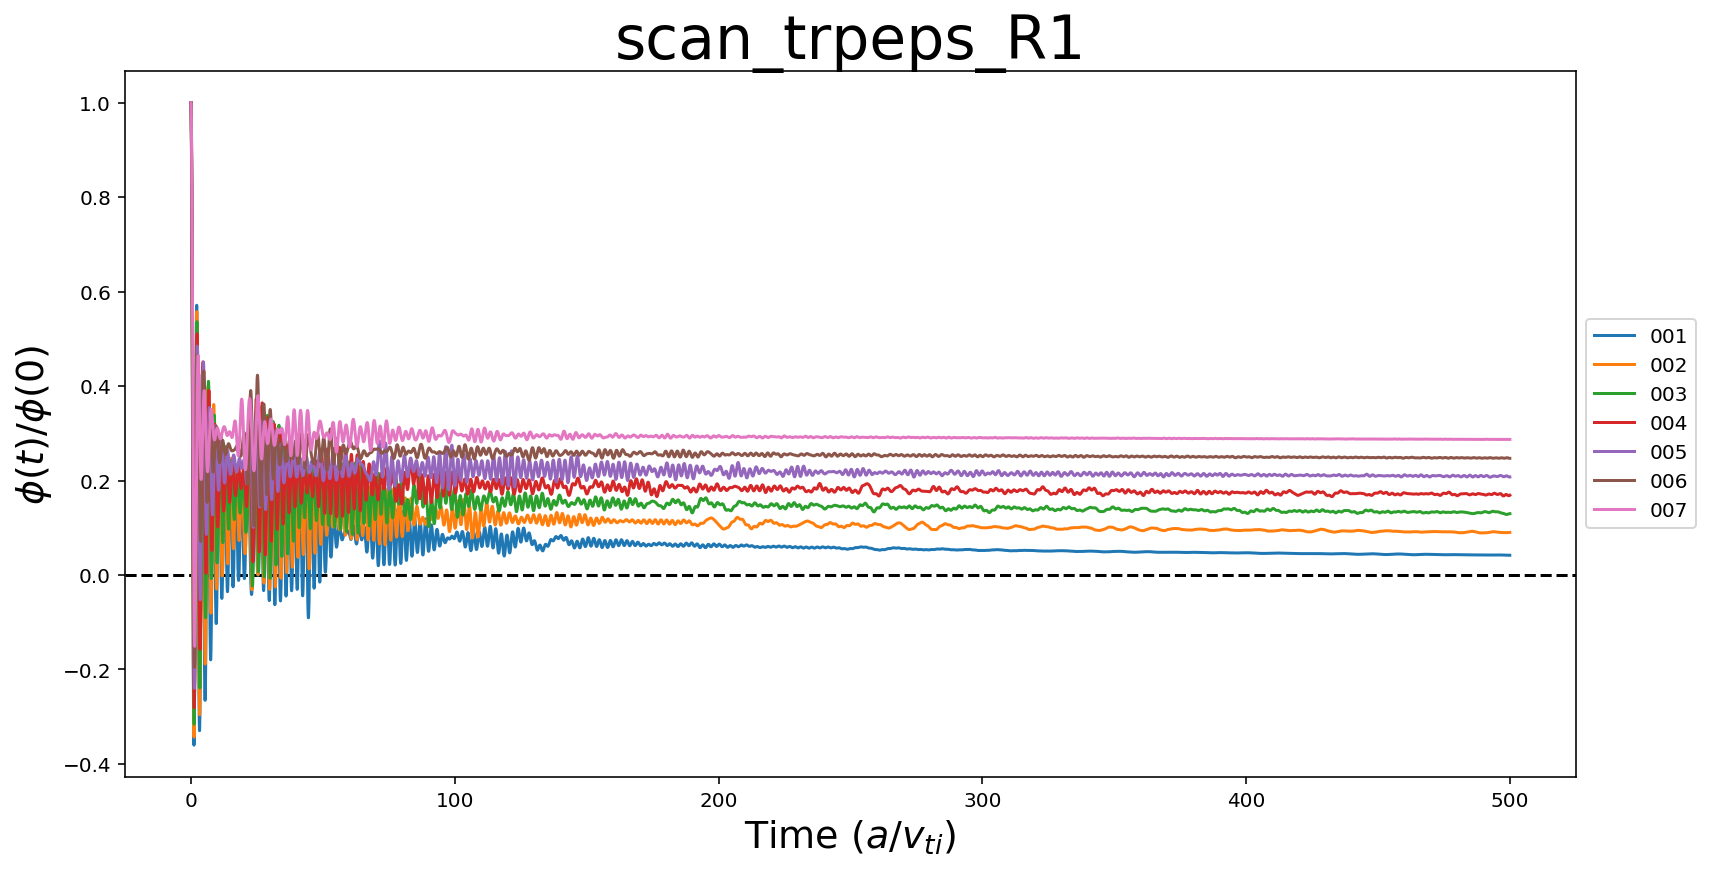

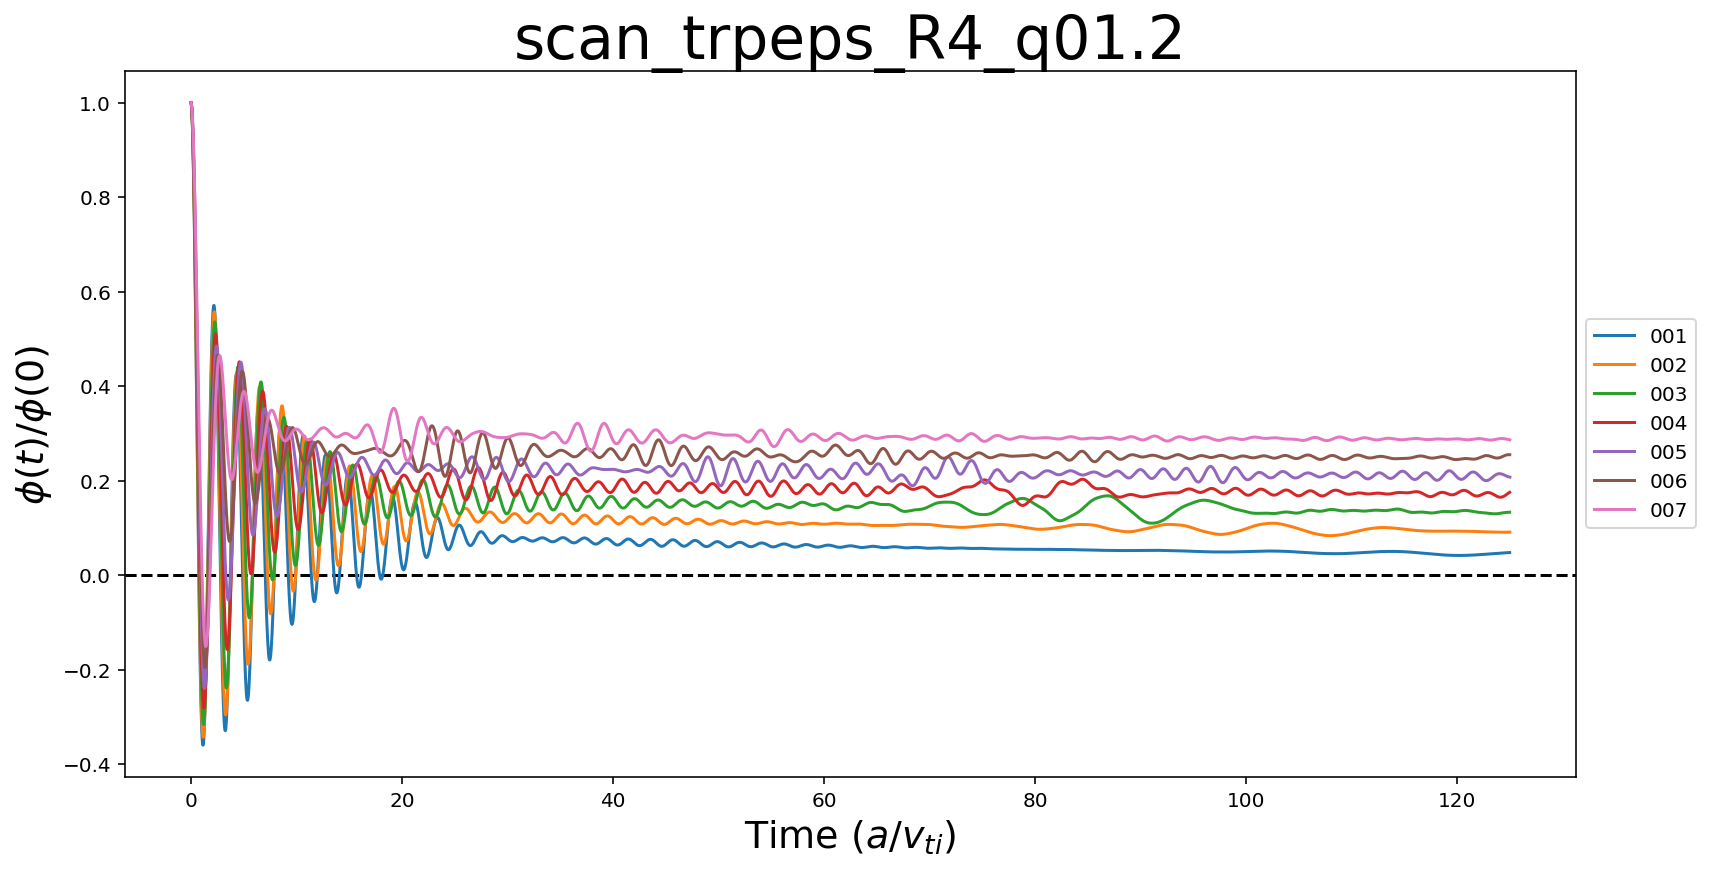

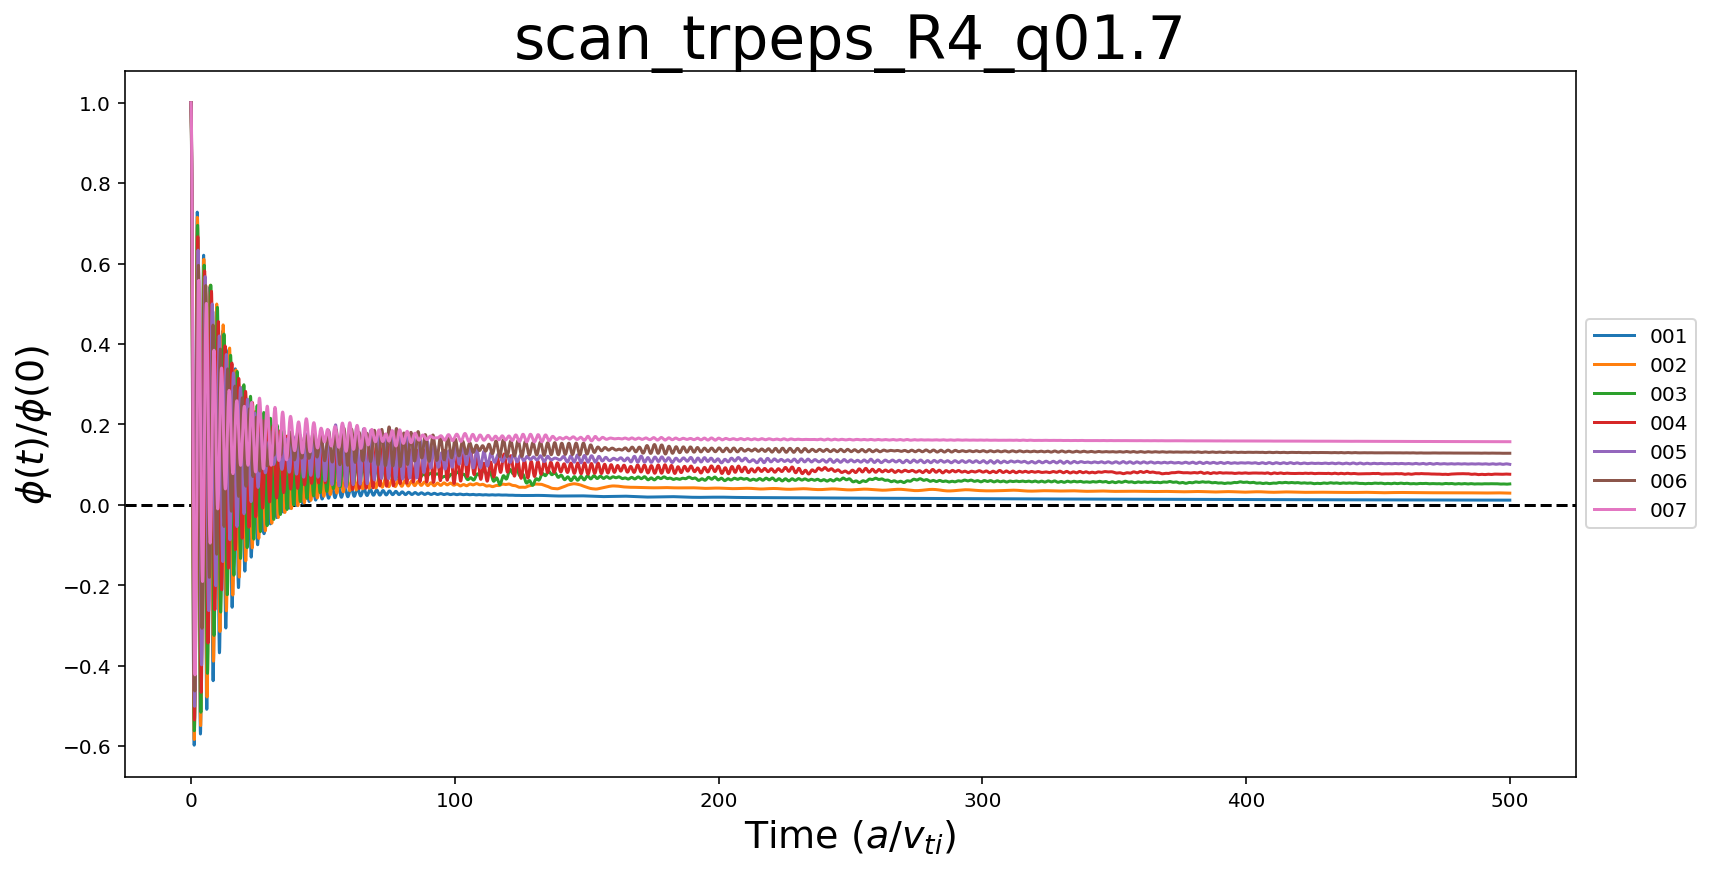

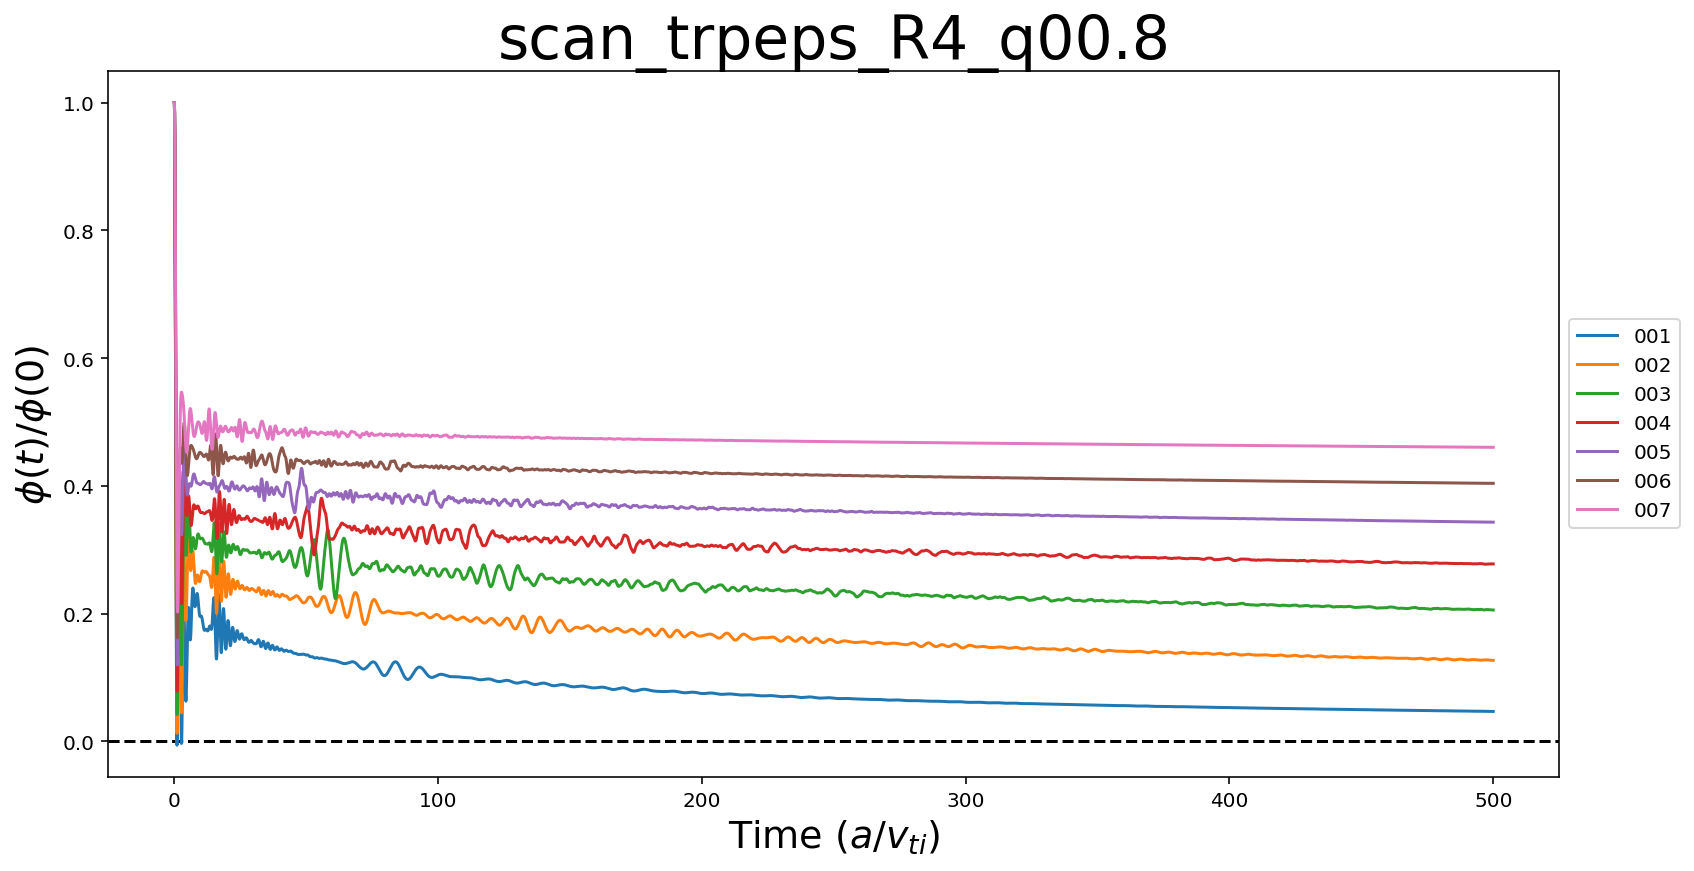

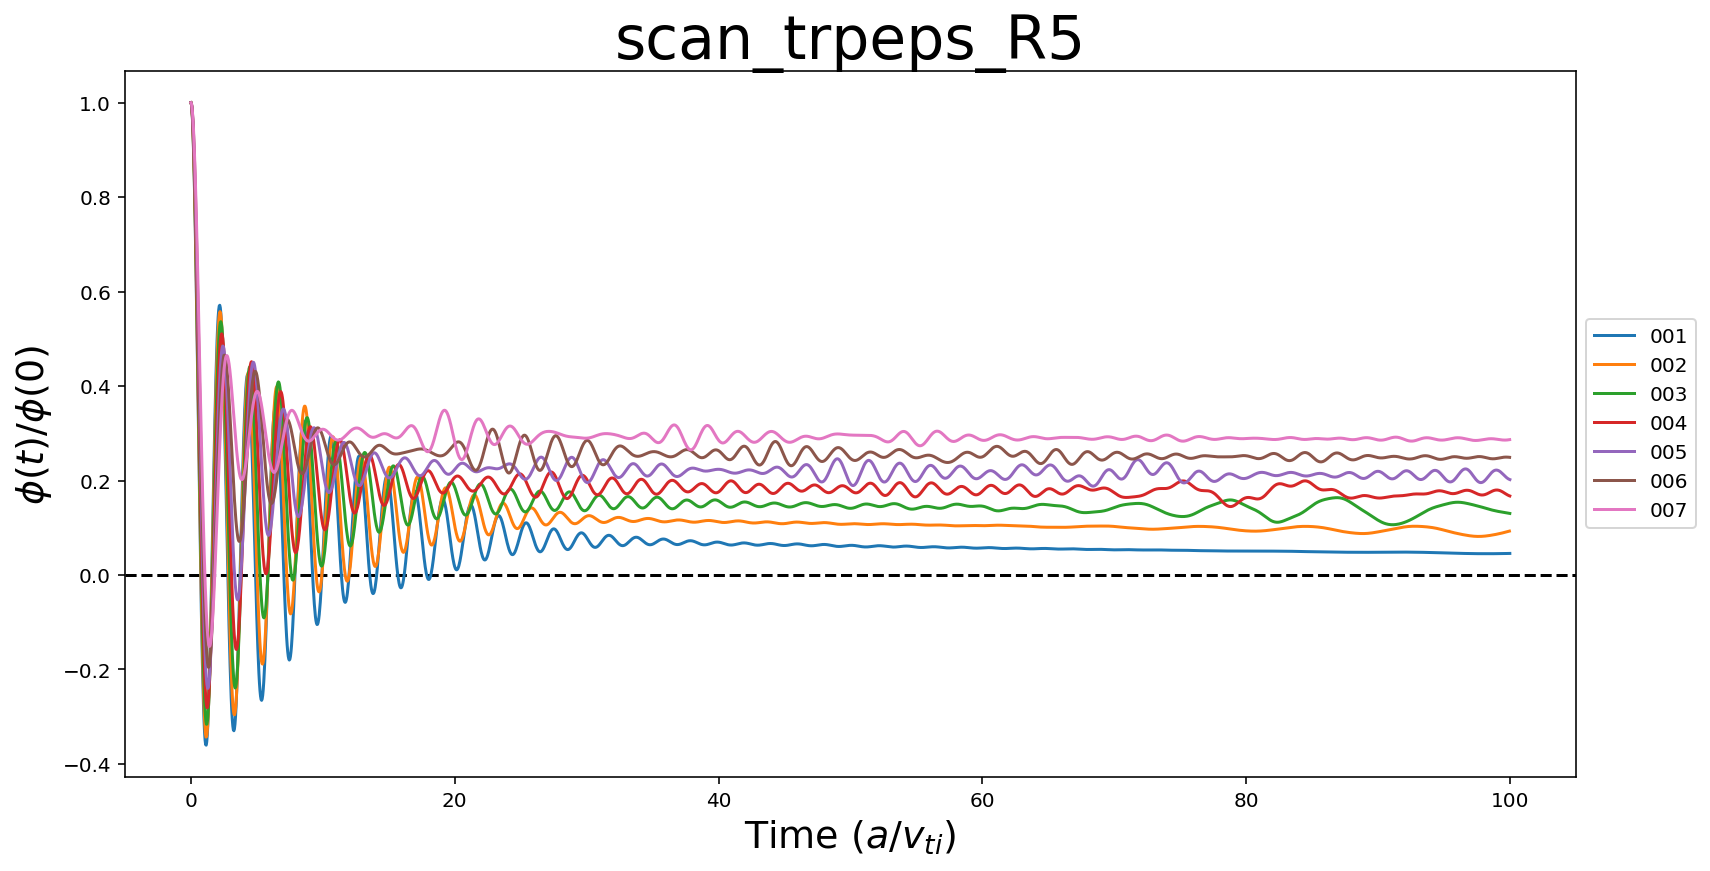

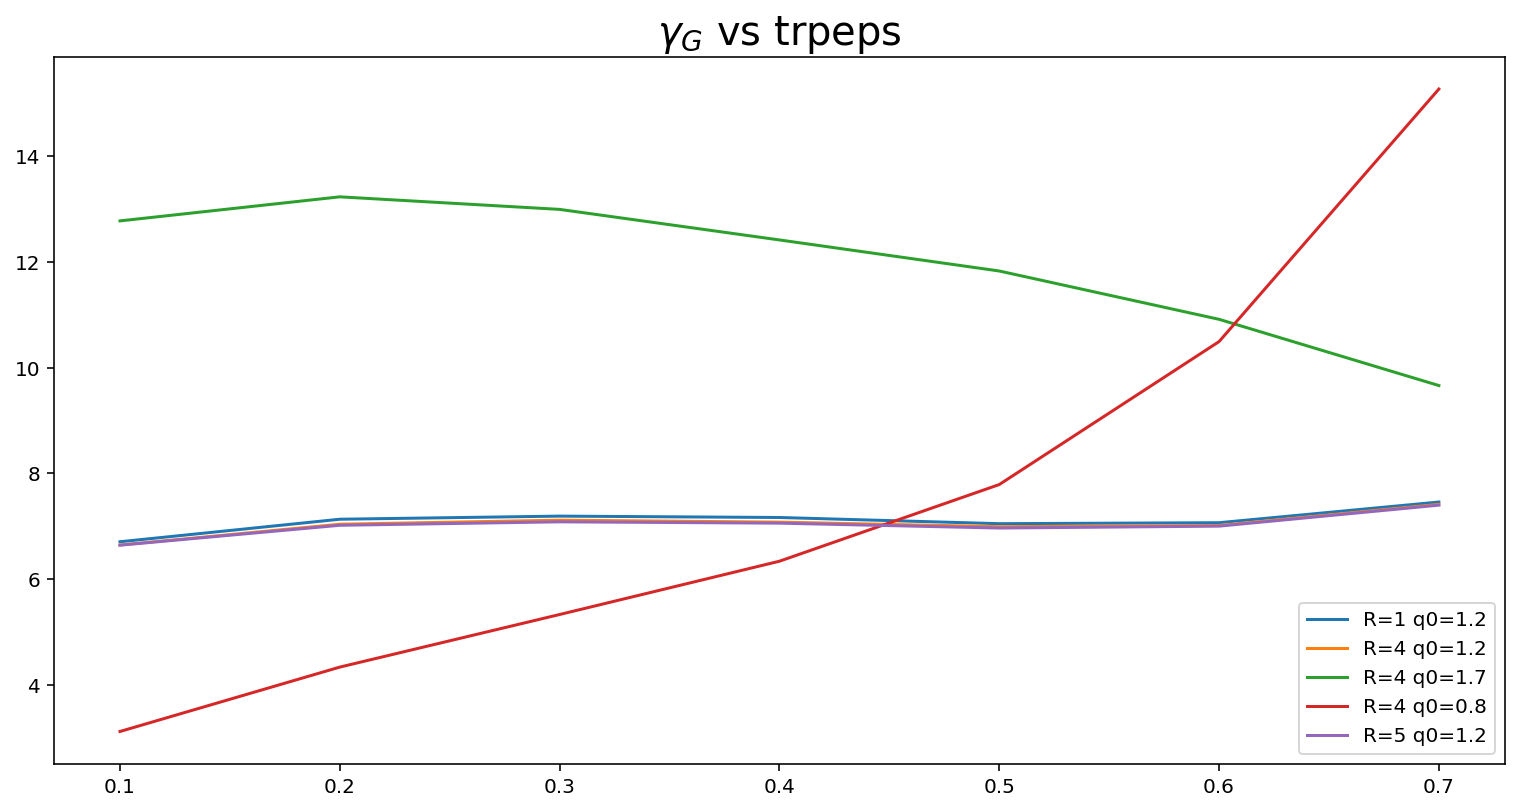

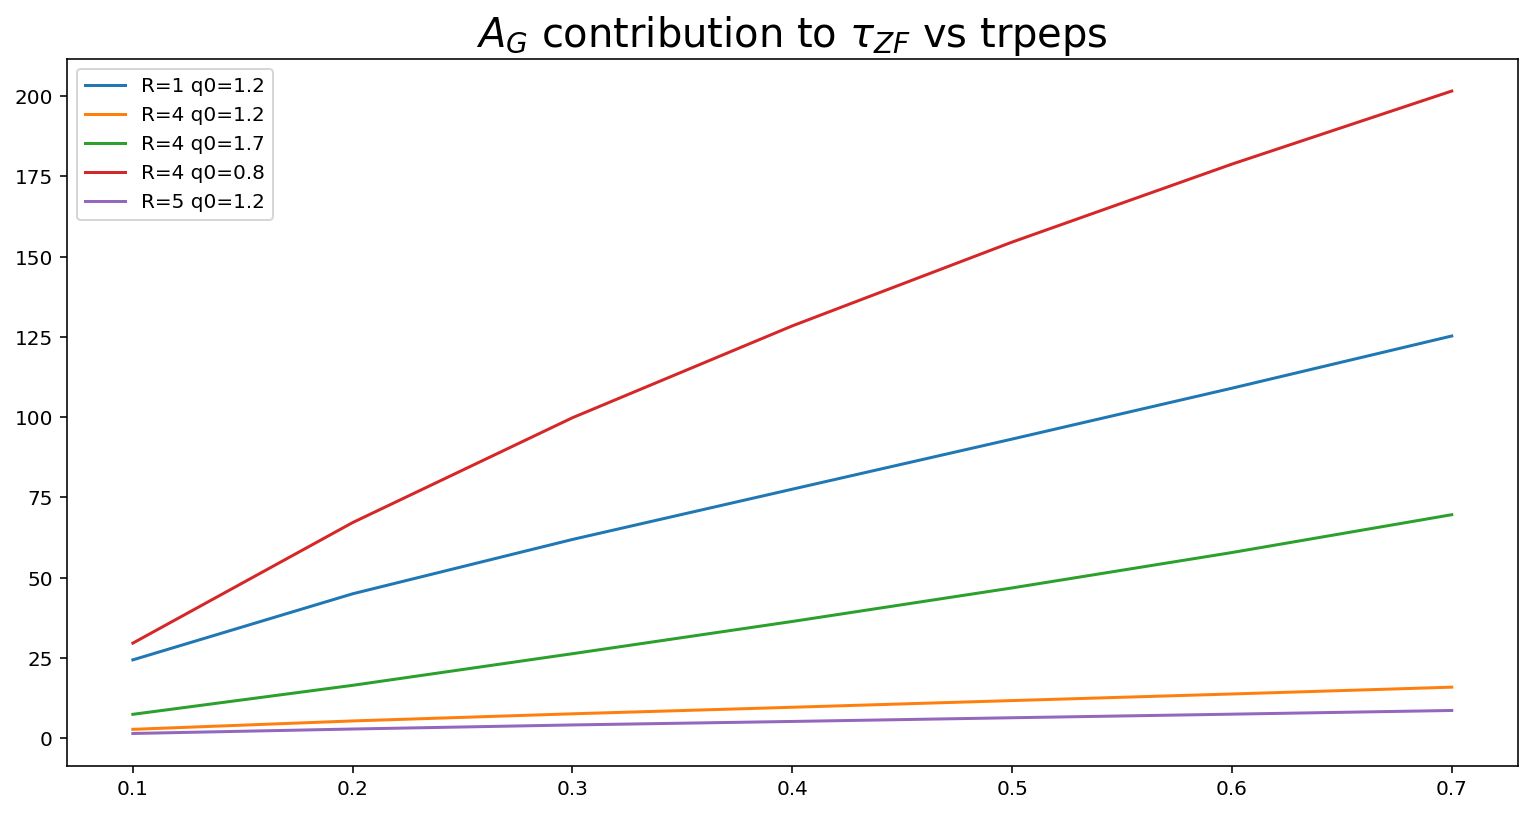

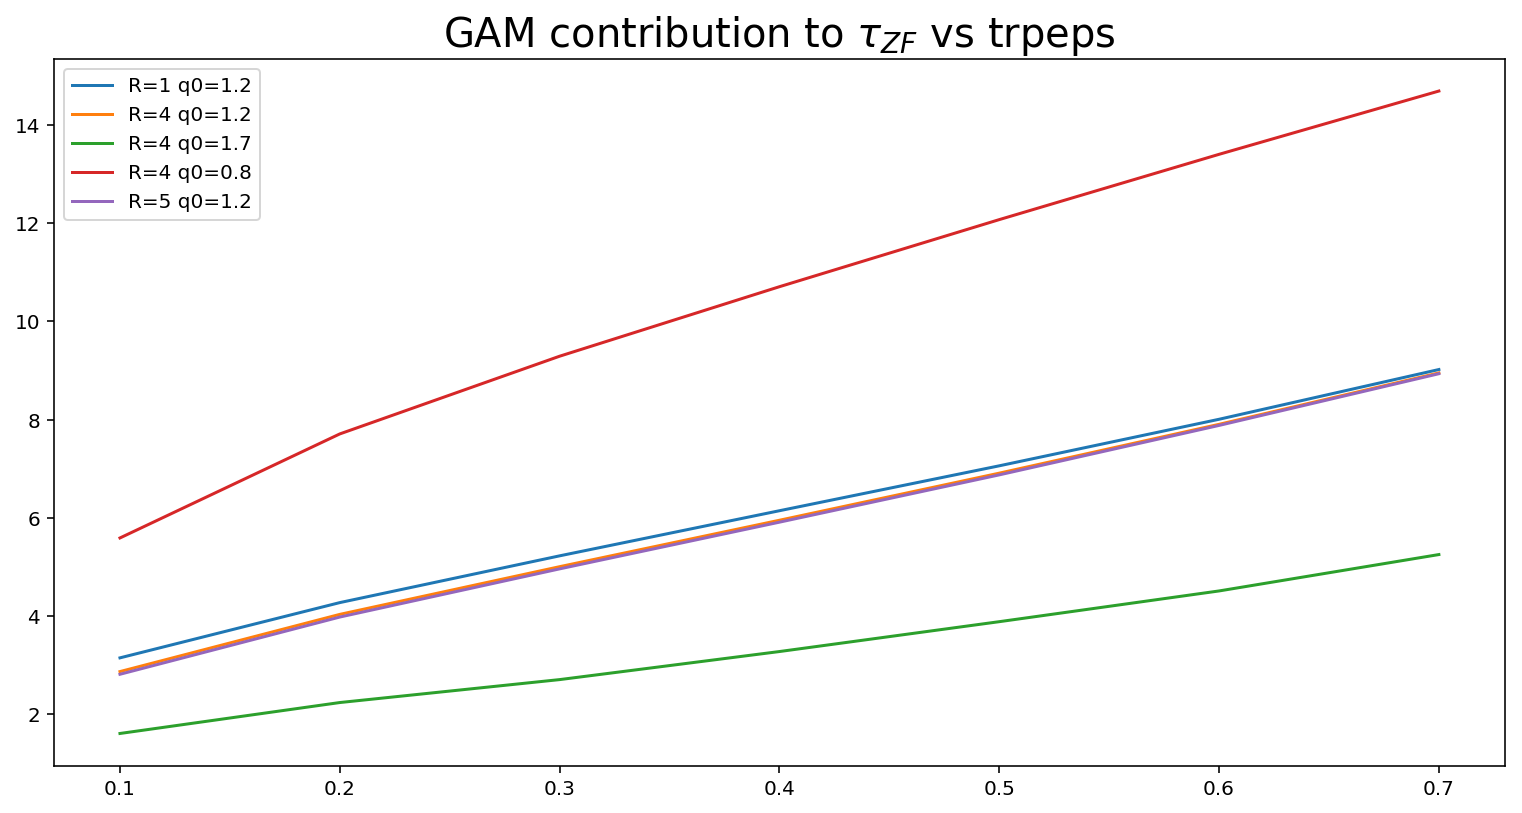

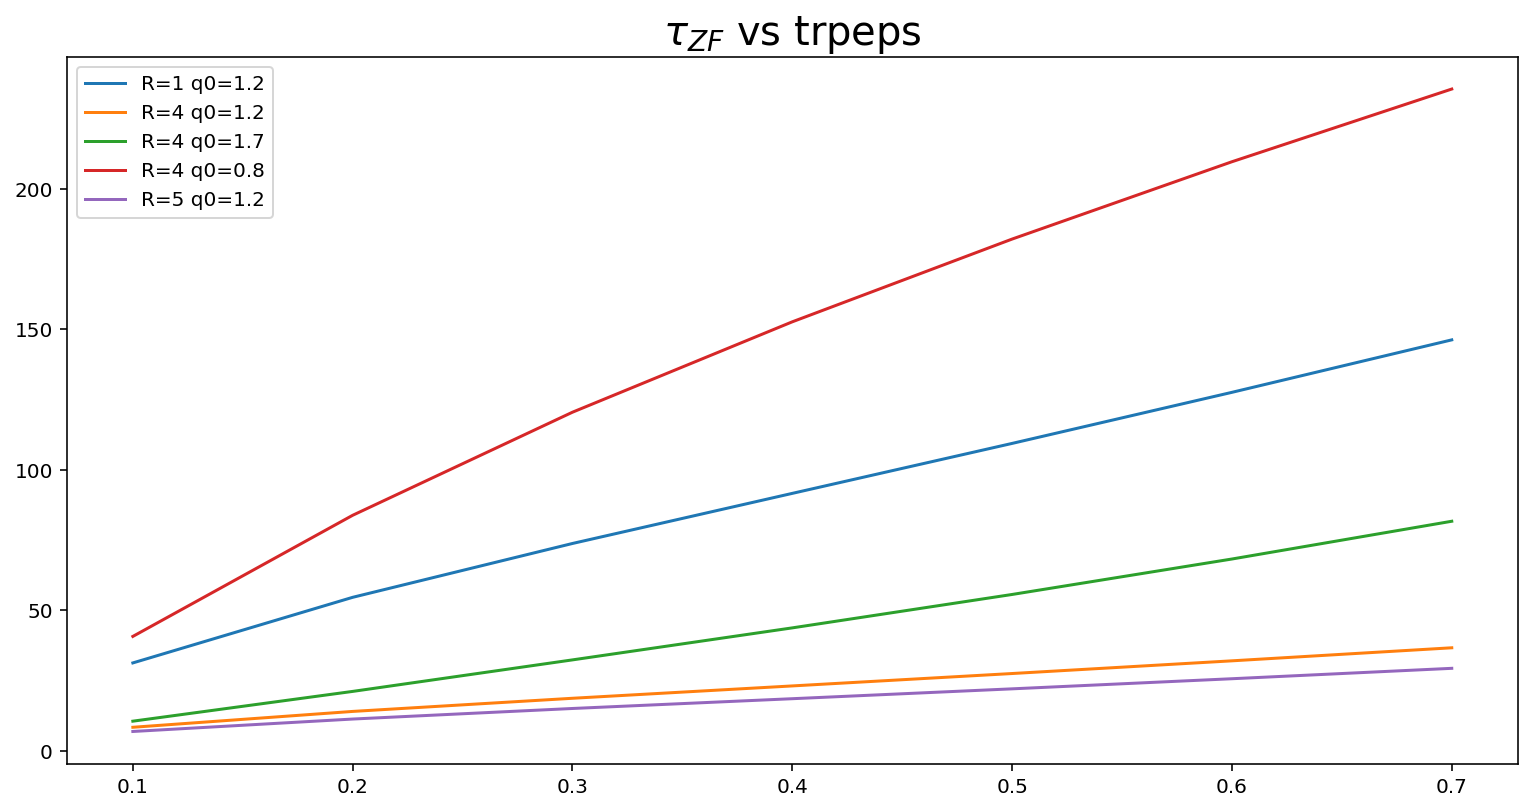

Diag mode on
Overshoot ratio (OS): 0.20200491203448448
Bump ratio (BR): 0.15109017091875093
Bump growth ratio (GR1): 0.6932515871702649
2nd growth ratio (GR2): 1.336982484076433
Period (PE): 2.4299999999999997
Peak time (TP): 3.8609999999999998


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


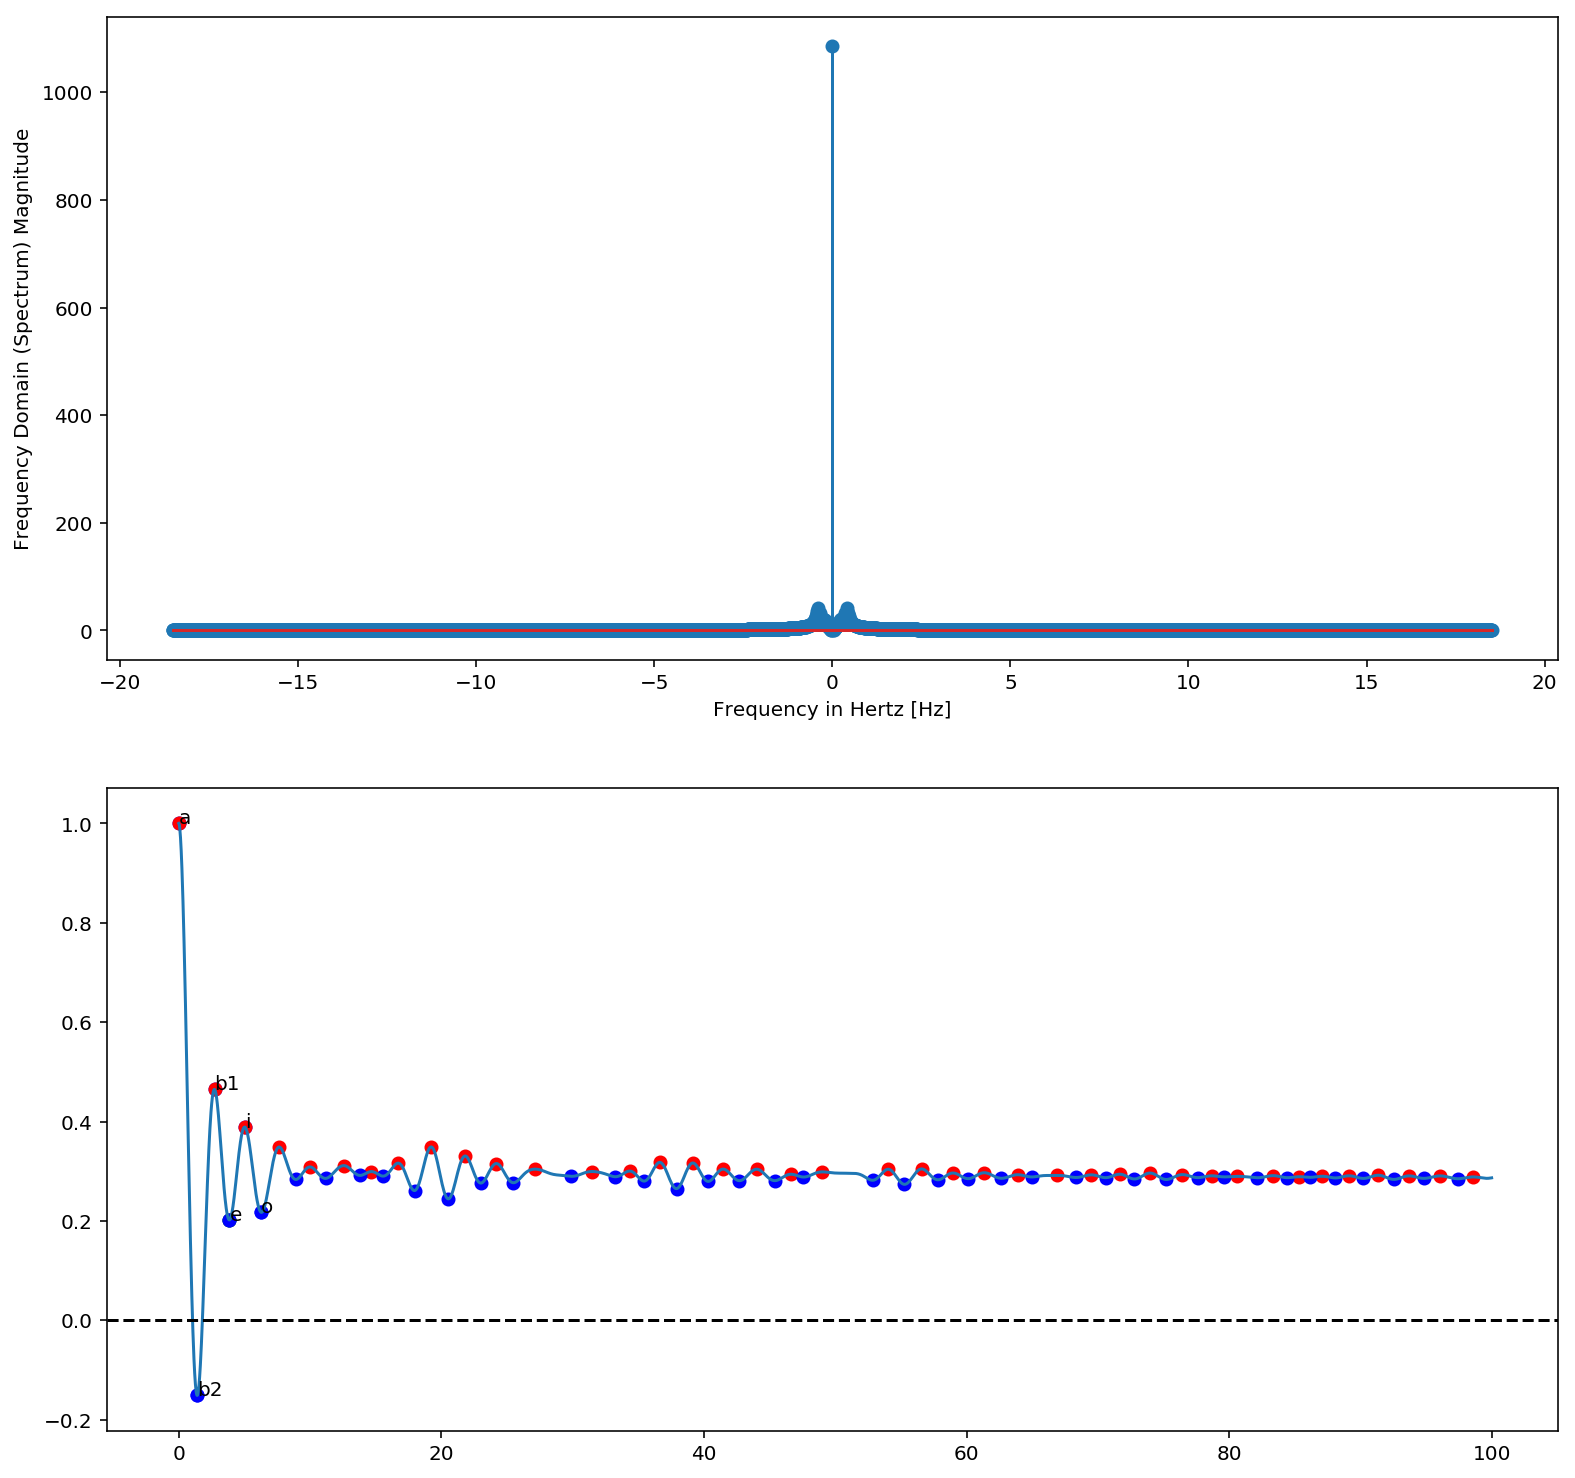

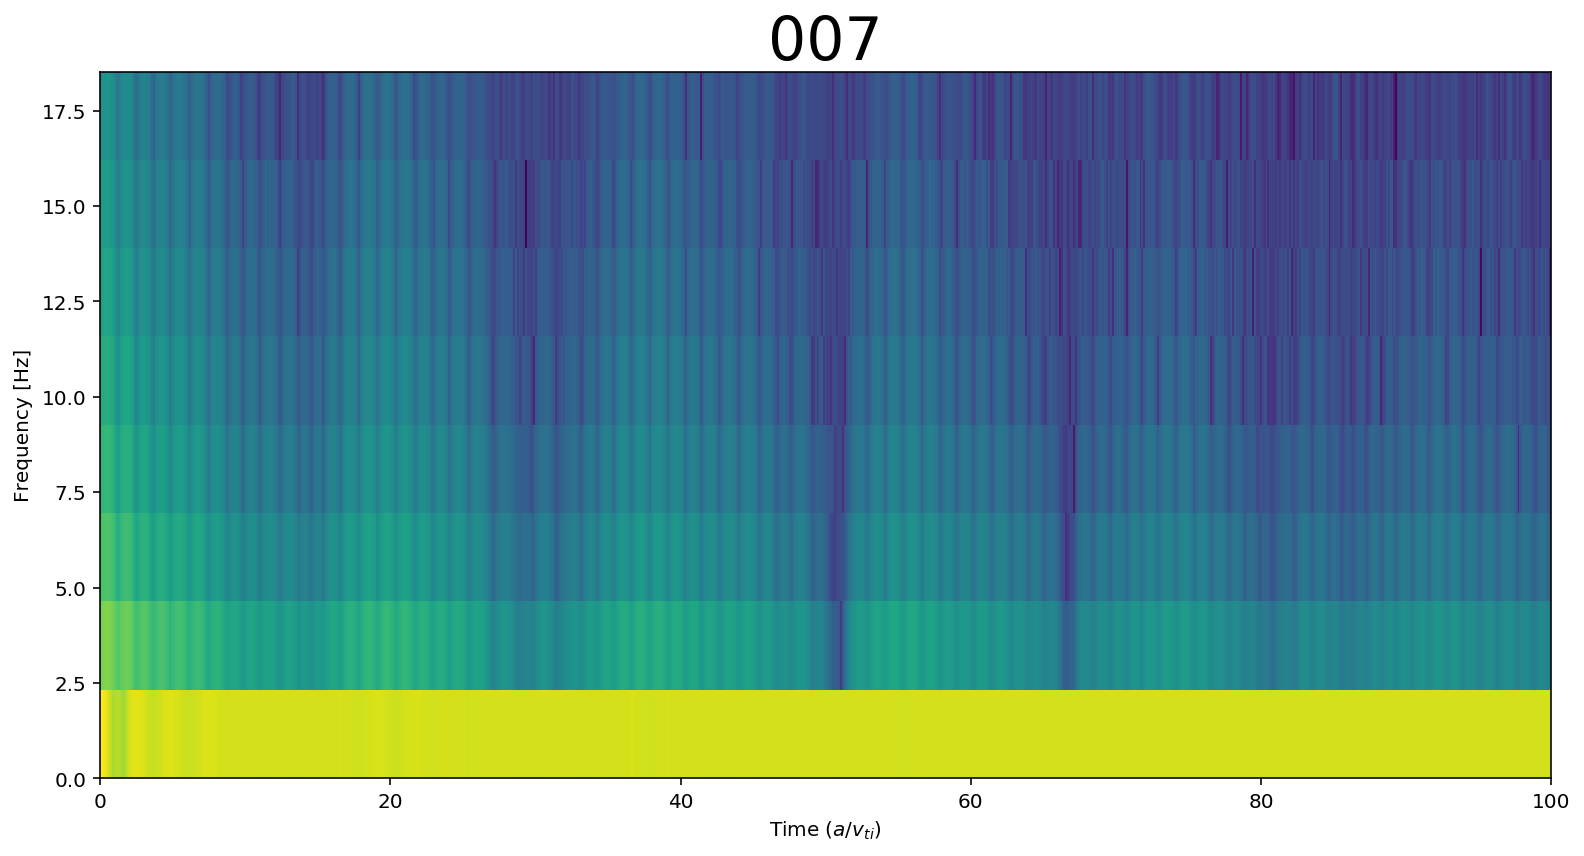

In [2]:
minlim=0
maxlim=7
kx, integR1, decayR1, gamR1, residR1, E, t, label = get_zf('scan_trpeps_R1', minlim, maxlim, plot=True, k=None, Lx=10, nkx0=2, dR=True, R=1)
kx, integR4, decayR4, gamR4, residR4, E, t, label = get_zf('scan_trpeps_R4_q01.2', minlim, maxlim, plot=True, k=None, Lx=10, nkx0=2, dR=True, R=4)
kx, integR4b, decayR4b, gamR4b, residR4b, E, t, label = get_zf('scan_trpeps_R4_q01.7', minlim, maxlim, plot=True, k=None, Lx=10, nkx0=2)
kx, integR4c, decayR4c, gamR4c, residR4c, E, t, label = get_zf('scan_trpeps_R4_q00.8', minlim, maxlim, plot=True, k=None, Lx=10, nkx0=2)
kx, integR5, decayR5, gamR5, residR5, E, t, label = get_zf('scan_trpeps_R5', minlim, maxlim, plot=True, k=None, Lx=10, nkx0=2, dR=True, R=5)

intefield = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

plt.figure(figsize=(13, 6.5))
plt.title("$\gamma_{G}$ vs trpeps", fontsize=20)
plt.plot(intefield[minlim:maxlim], decayR1, label='R=1 q0=1.2')
plt.plot(intefield[minlim:maxlim], decayR4, label='R=4 q0=1.2')
plt.plot(intefield[minlim:maxlim], decayR4b, label='R=4 q0=1.7')
plt.plot(intefield[minlim:maxlim], decayR4c, label='R=4 q0=0.8')
plt.plot(intefield[minlim:maxlim], decayR5, label='R=5 q0=1.2')
plt.legend()
plt.show()

plt.figure(figsize=(13, 6.5))
plt.title("$A_{G}$ contribution to $\\tau_{ZF}$ vs trpeps", fontsize=20)
plt.plot(intefield[minlim:maxlim], residR1, label='R=1 q0=1.2')
plt.plot(intefield[minlim:maxlim], residR4, label='R=4 q0=1.2')
plt.plot(intefield[minlim:maxlim], residR4b, label='R=4 q0=1.7')
plt.plot(intefield[minlim:maxlim], residR4c, label='R=4 q0=0.8')
plt.plot(intefield[minlim:maxlim], residR5, label='R=5 q0=1.2')
plt.legend()
plt.show()

plt.figure(figsize=(13, 6.5))
plt.title("GAM contribution to $\\tau_{ZF}$ vs trpeps", fontsize=20)
plt.plot(intefield[minlim:maxlim], gamR1, label='R=1 q0=1.2')
plt.plot(intefield[minlim:maxlim], gamR4, label='R=4 q0=1.2')
plt.plot(intefield[minlim:maxlim], gamR4b, label='R=4 q0=1.7')
plt.plot(intefield[minlim:maxlim], gamR4c, label='R=4 q0=0.8')
plt.plot(intefield[minlim:maxlim], gamR5, label='R=5 q0=1.2')
plt.legend()
plt.show()

plt.figure(figsize=(13, 6.5))
plt.title("$\\tau_{ZF}$ vs trpeps", fontsize=20)
plt.plot(intefield[minlim:maxlim], integR1, label='R=1 q0=1.2')
plt.plot(intefield[minlim:maxlim], integR4, label='R=4 q0=1.2')
plt.plot(intefield[minlim:maxlim], integR4b, label='R=4 q0=1.7')
plt.plot(intefield[minlim:maxlim], integR4c, label='R=4 q0=0.8')
plt.plot(intefield[minlim:maxlim], integR5, label='R=5 q0=1.2')
plt.legend()
plt.show()
troubleshooter(E, t, label)  #, spectrogram=True)

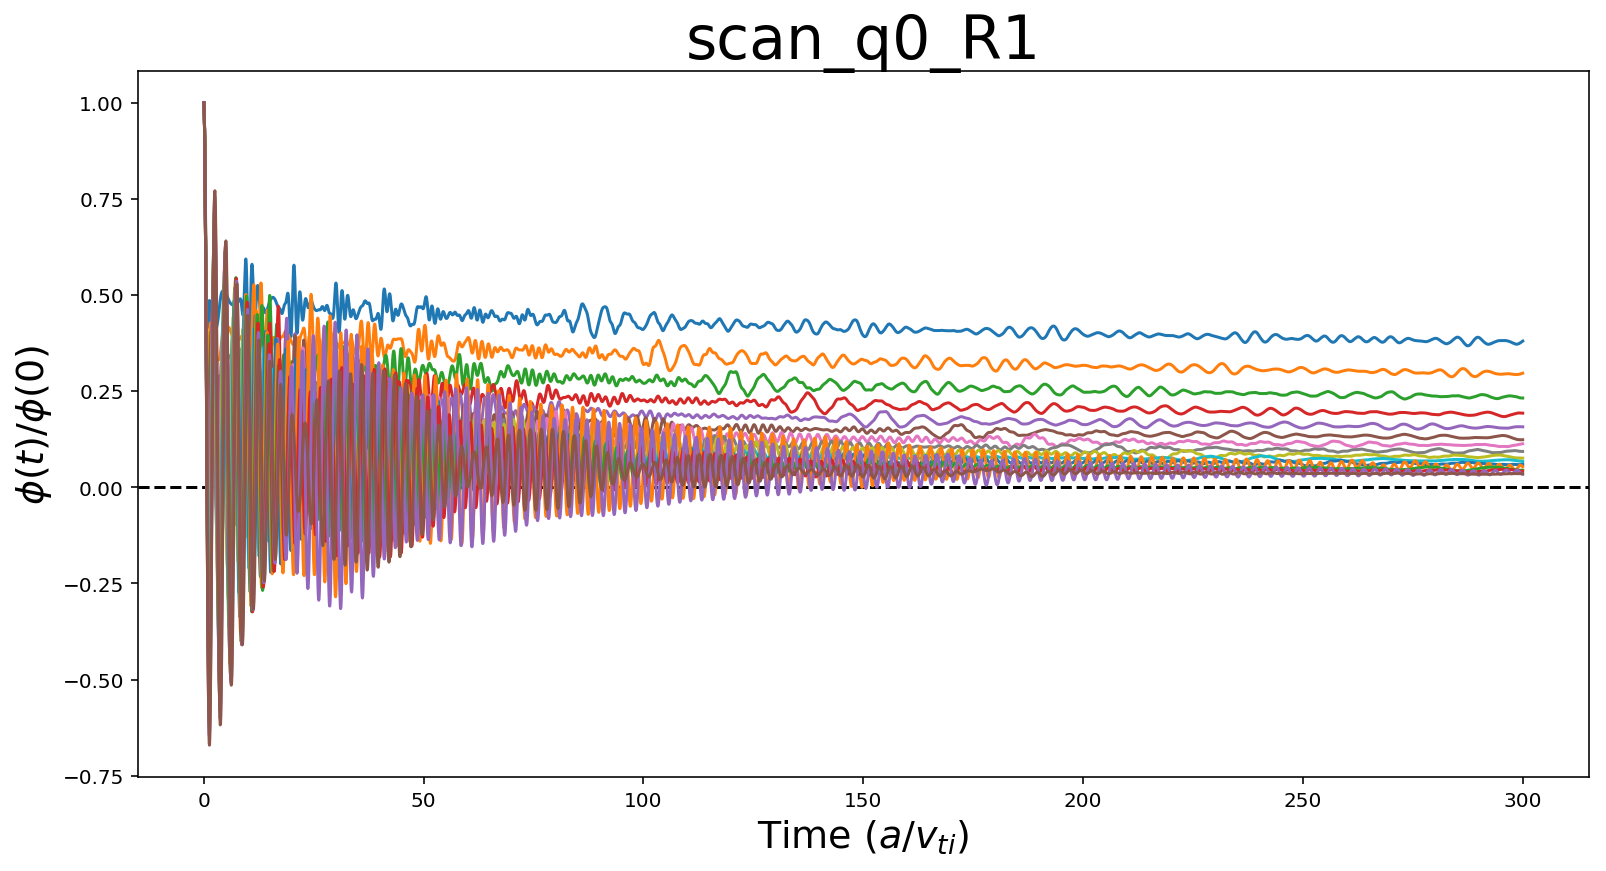

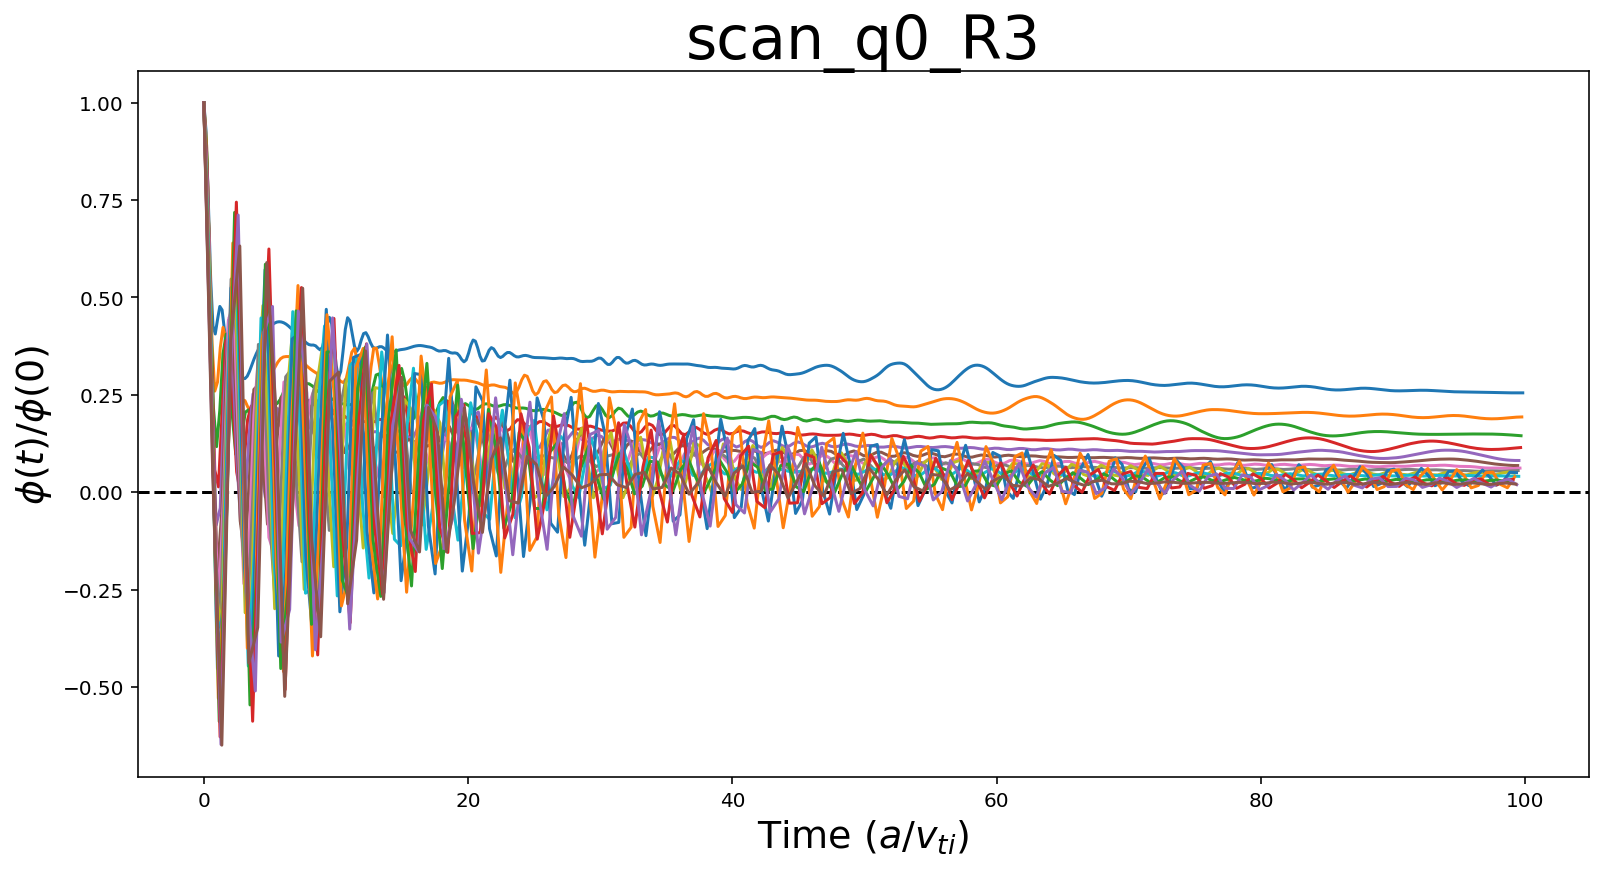

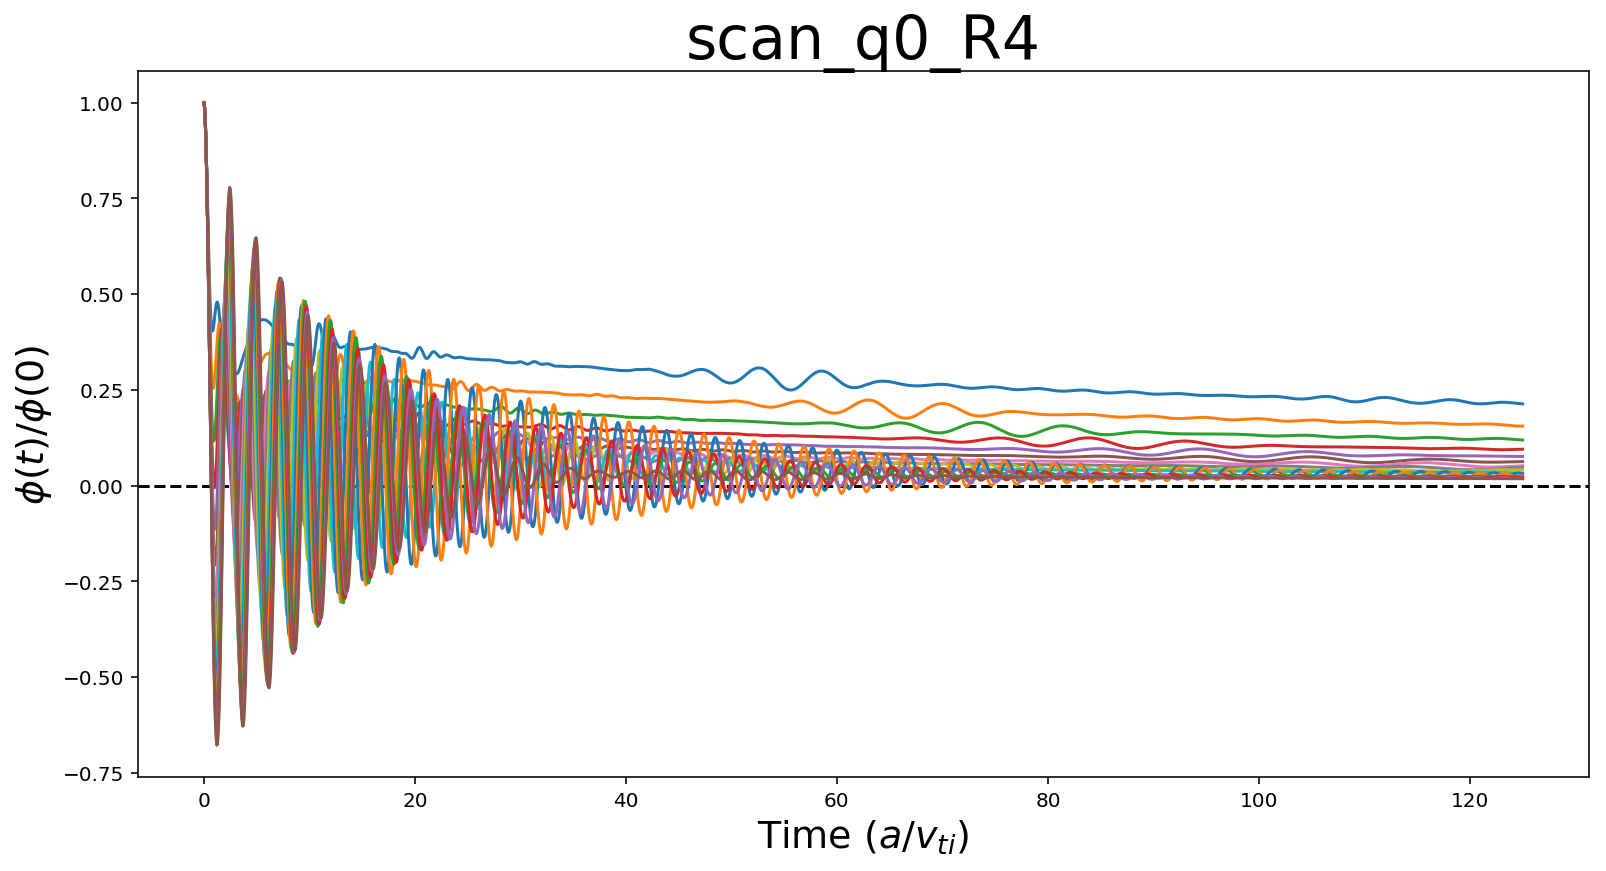

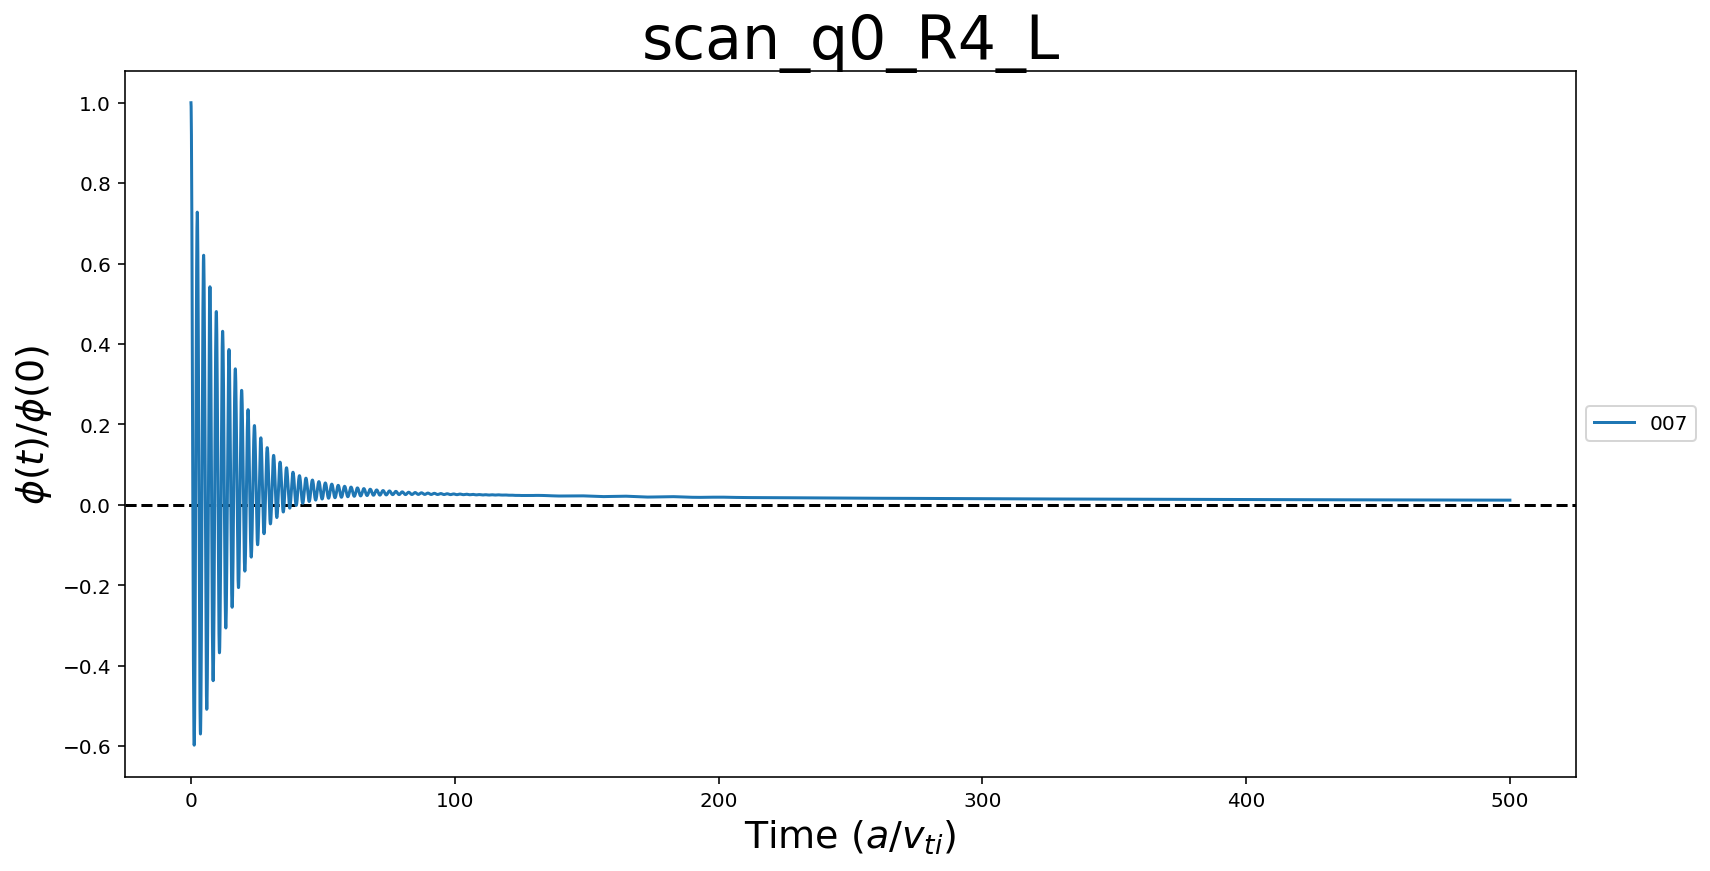

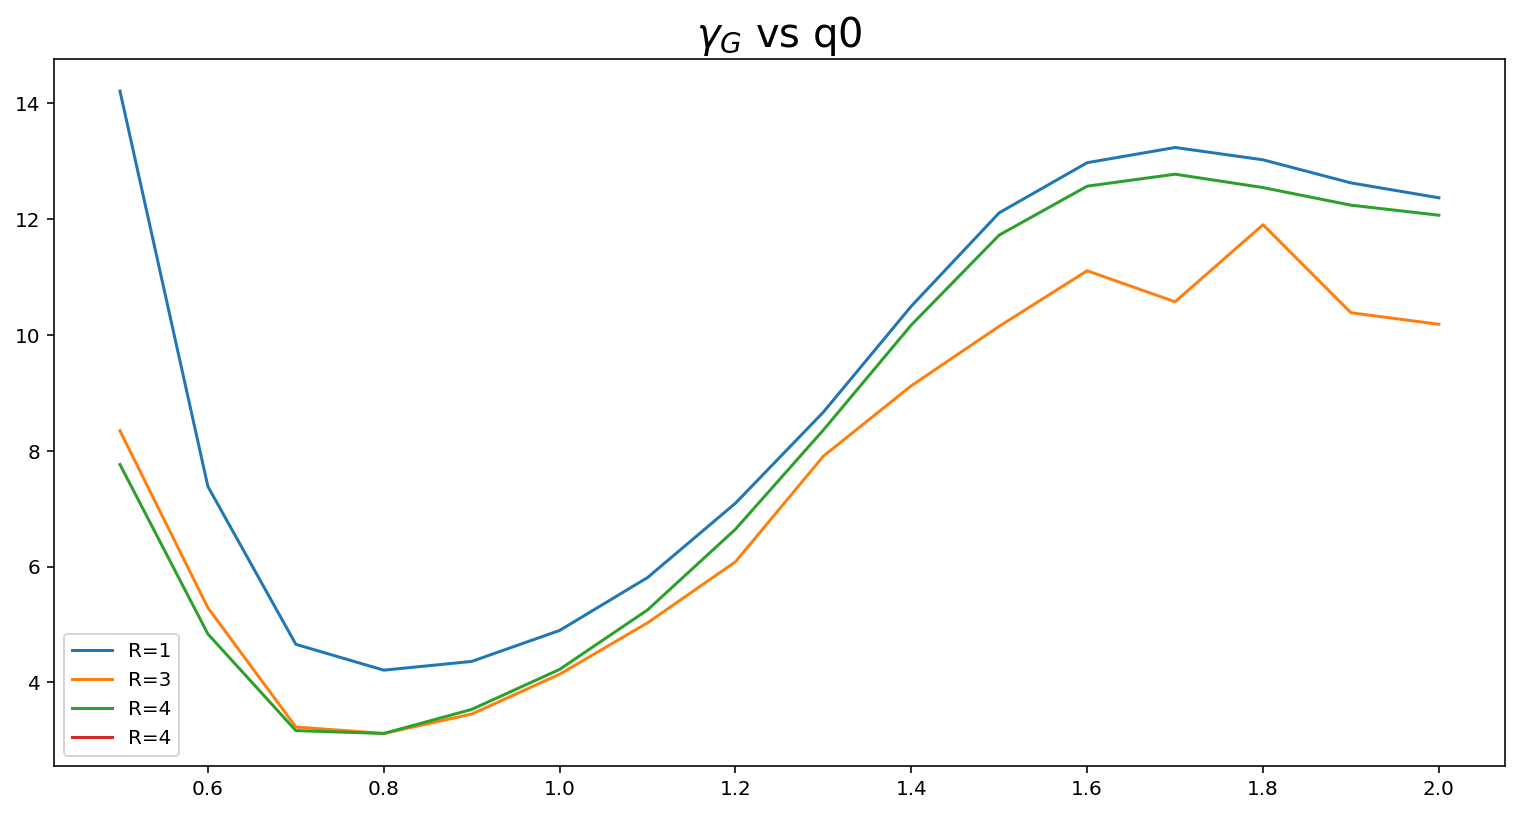

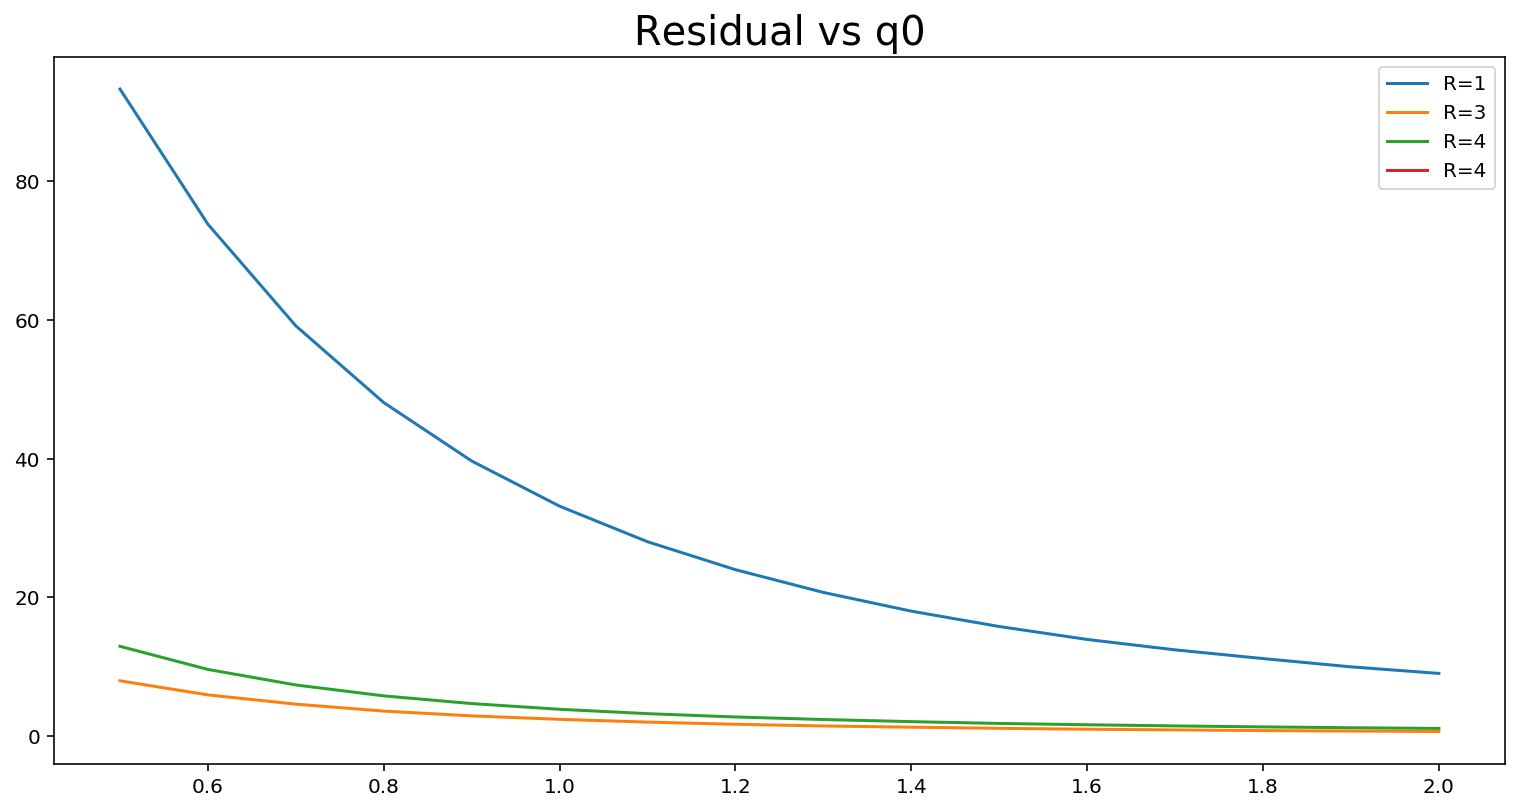

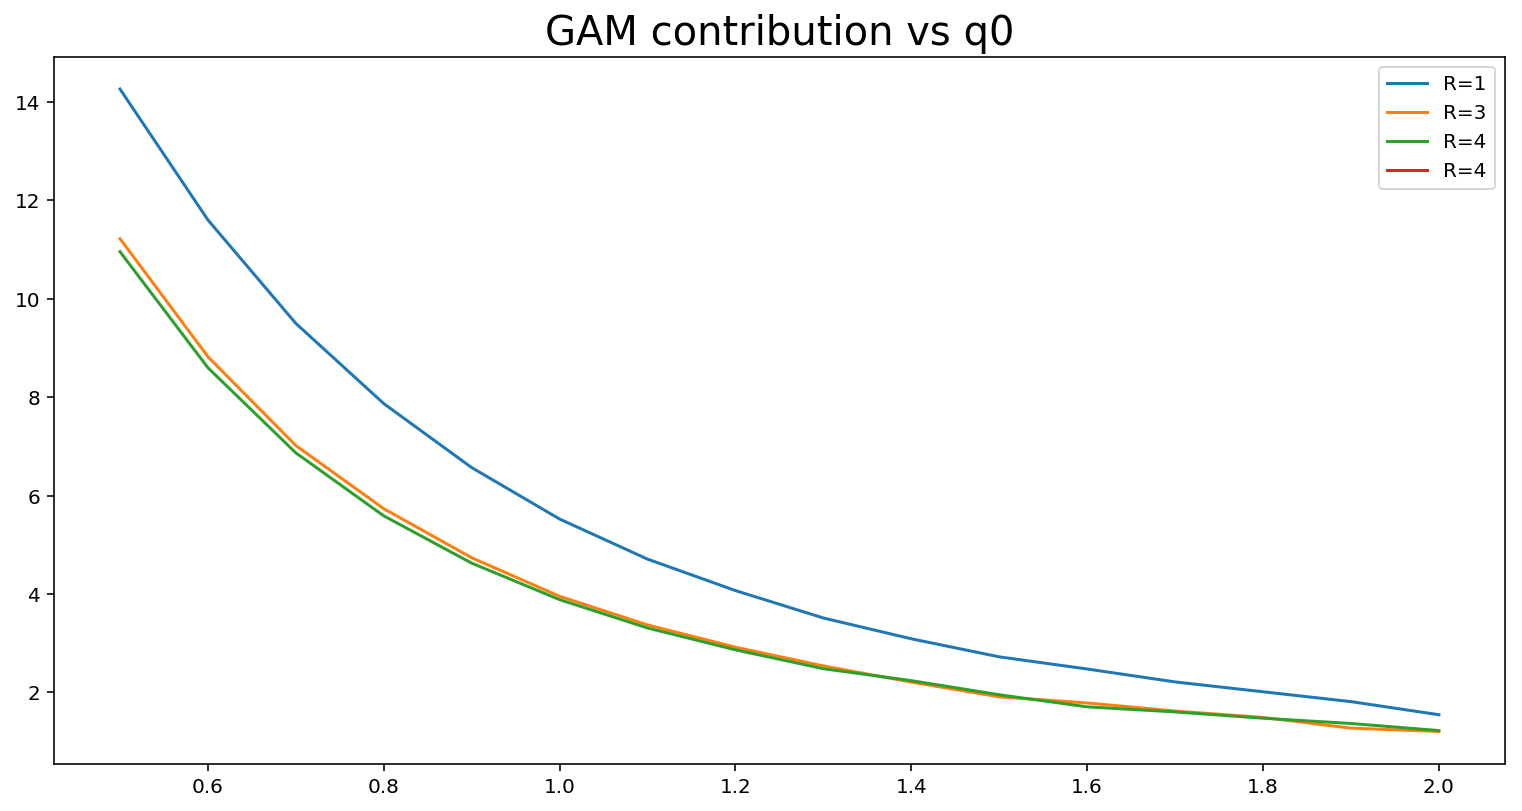

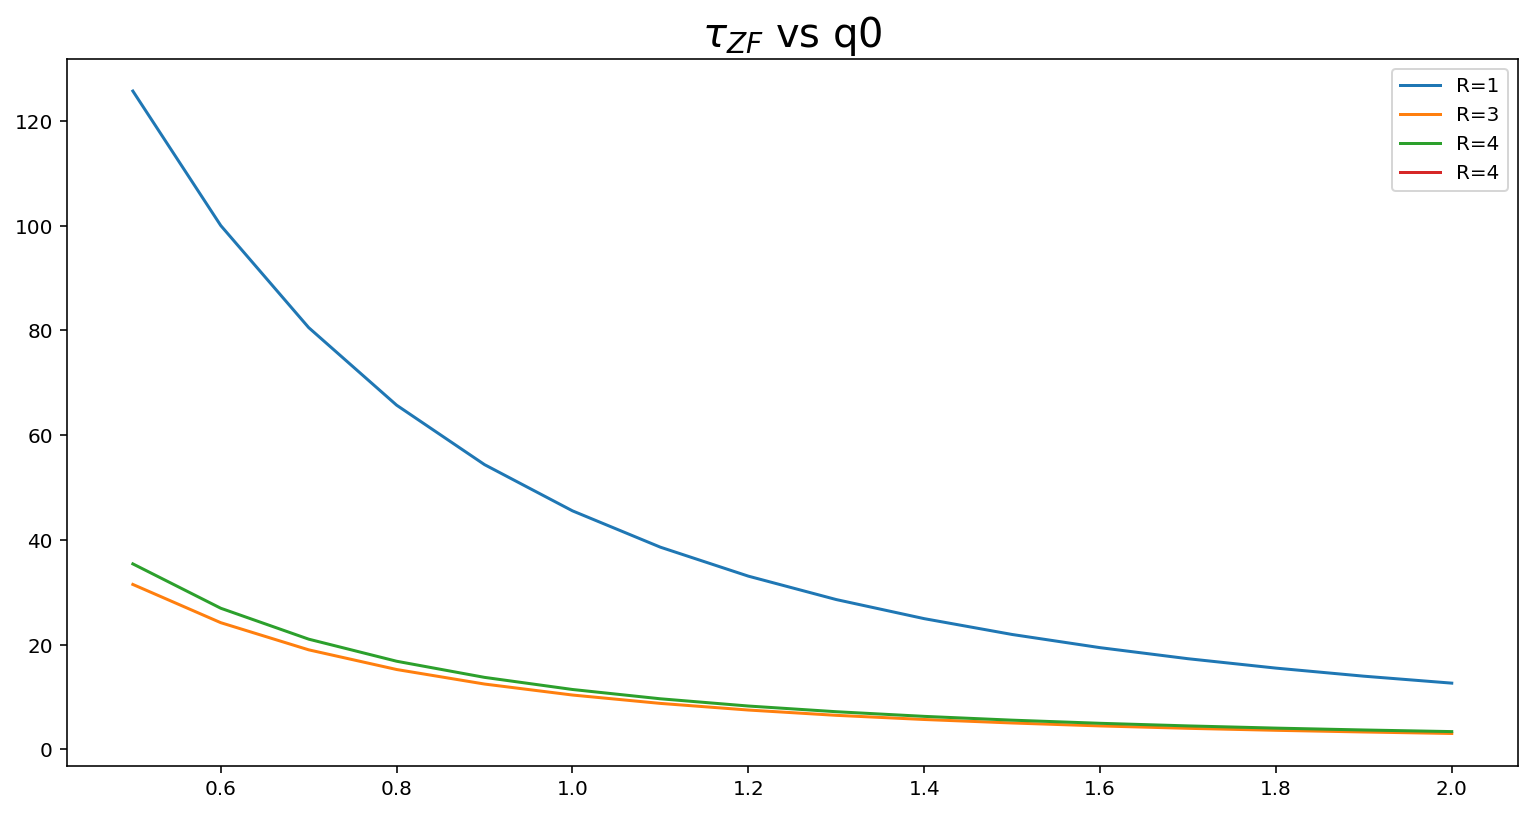

In [3]:
minlim=0
maxlim=16
minlim2=6
maxlim2=7
kx, integR1, decayR1, gamR1, residR1, E, t, label = get_zf('scan_q0_R1', minlim, maxlim, plot=True, k=None, Lx=100, nkx0=2, dR=True, R=1)
kx, integR3, decayR3, gamR3, residR3, E, t, label = get_zf('scan_q0_R3', minlim, maxlim, plot=True, k=None, Lx=100, nkx0=2, dR=True, R=3)
kx, integR4, decayR4, gamR4, residR4, E, t, label = get_zf('scan_q0_R4', minlim, maxlim, plot=True, k=None, Lx=100, nkx0=2, dR=True, R=4)
kx, integR4L, decayR4L, gamR4L, residR4L, E, t, label = get_zf('scan_q0_R4_L', minlim2, maxlim2, plot=True, k=None, Lx=100, nkx0=2)

intefield = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
intefield2 = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9, 5.1, 5.3]

plt.figure(figsize=(13, 6.5))
plt.title("$\gamma_{G}$ vs q0", fontsize=20)
plt.plot(intefield[minlim:maxlim], decayR1, label='R=1')
plt.plot(intefield[minlim:maxlim], decayR3, label='R=3')
plt.plot(intefield[minlim:maxlim], decayR4, label='R=4')
plt.plot(intefield2[minlim2:maxlim2], decayR4L, label='R=4')
plt.legend()
plt.show()

plt.figure(figsize=(13, 6.5))
plt.title("Residual vs q0", fontsize=20)
plt.plot(intefield[minlim:maxlim], residR1, label='R=1')
plt.plot(intefield[minlim:maxlim], residR3, label='R=3')
plt.plot(intefield[minlim:maxlim], residR4, label='R=4')
plt.plot(intefield2[minlim2:maxlim2], residR4L, label='R=4')
plt.legend()
plt.show()

plt.figure(figsize=(13, 6.5))
plt.title("GAM contribution vs q0", fontsize=20)
plt.plot(intefield[minlim:maxlim], gamR1, label='R=1')
plt.plot(intefield[minlim:maxlim], gamR3, label='R=3')
plt.plot(intefield[minlim:maxlim], gamR4, label='R=4')
plt.plot(intefield2[minlim2:maxlim2], gamR4L, label='R=4')
plt.legend()
plt.show()

plt.figure(figsize=(13, 6.5))
plt.title("$\\tau_{ZF}$ vs q0", fontsize=20)
plt.plot(intefield[minlim:maxlim], integR1, label='R=1')
plt.plot(intefield[minlim:maxlim], integR3, label='R=3')
plt.plot(intefield[minlim:maxlim], integR4, label='R=4')
plt.plot(intefield2[minlim2:maxlim2], integR4L, label='R=4')
plt.legend()
plt.show()

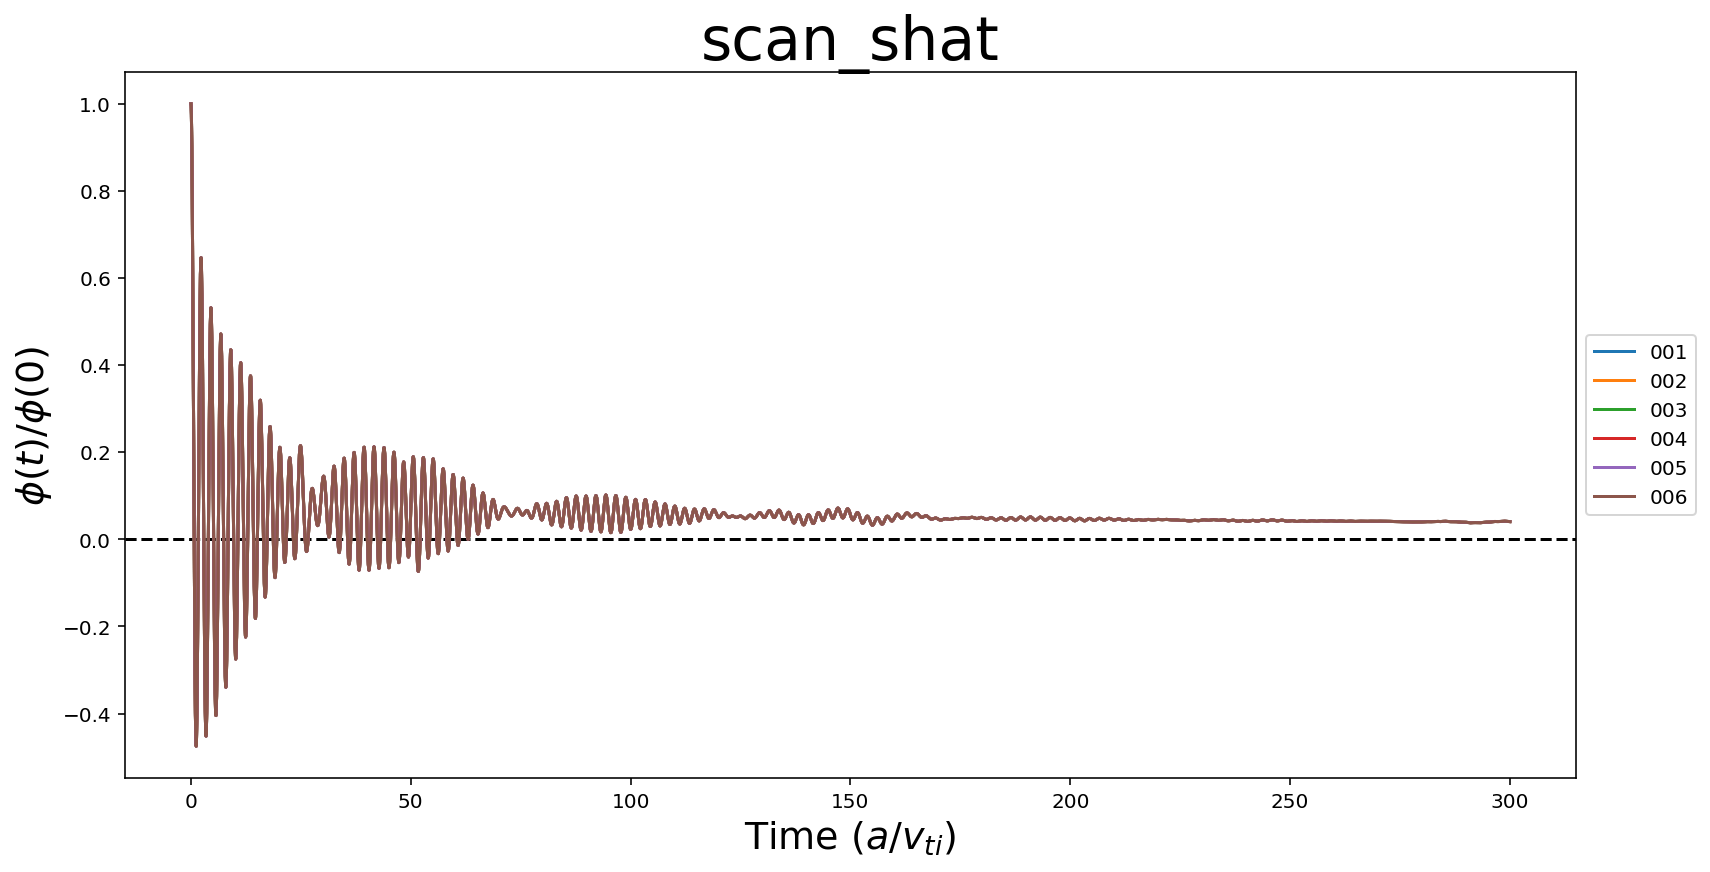

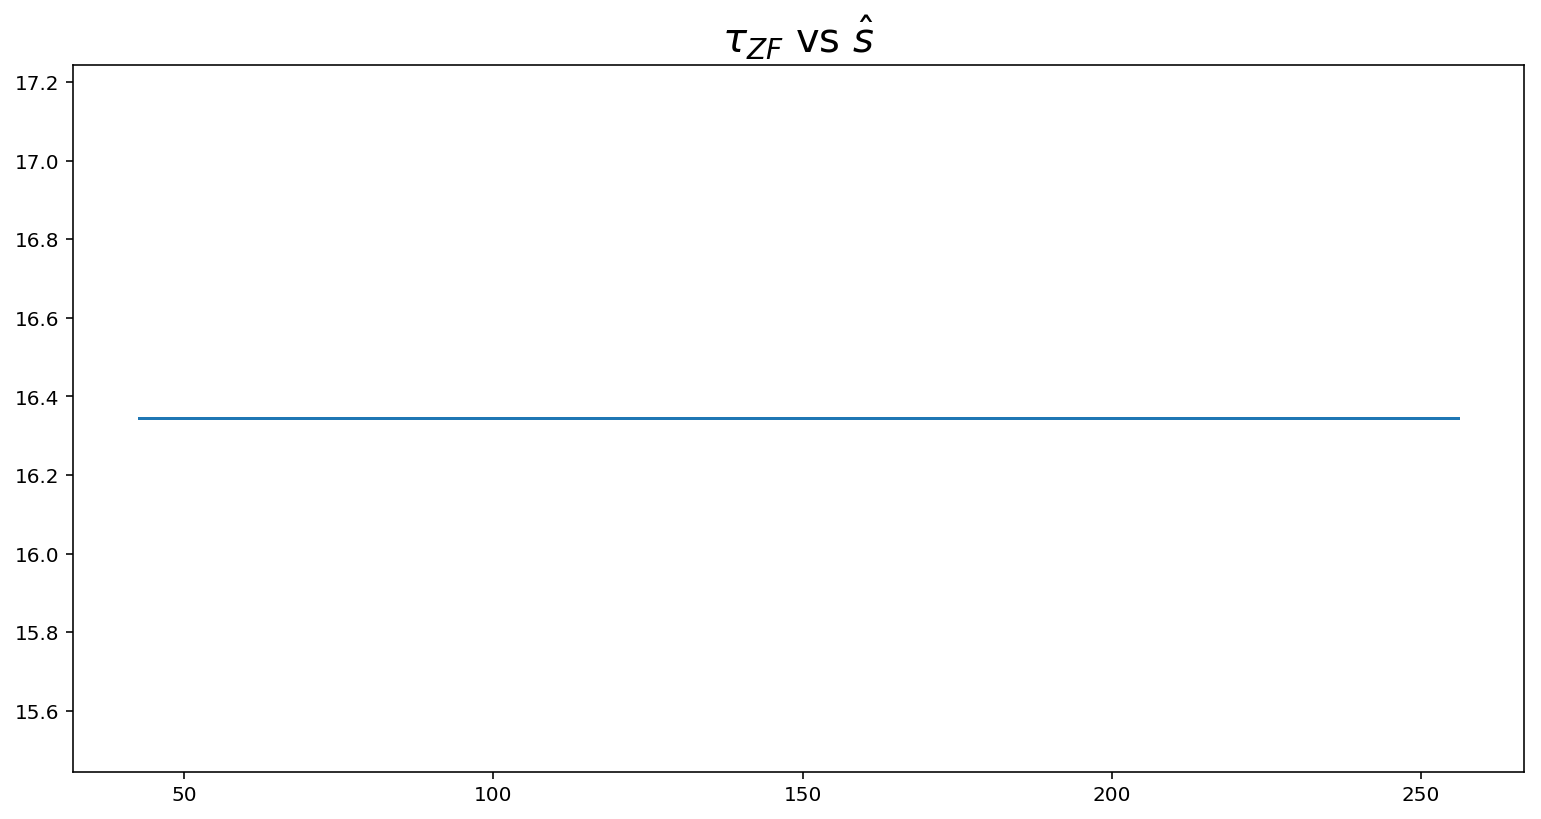

In [14]:
minlim=0
maxlim=6
kx, integ, decay, gam, resid, E, t, label = get_zf('scan_shat', minlim, maxlim, plot=True, k=None, Lx=100, nkx0=2)
plt.figure(figsize=(13, 6.5))
plt.title("$\\tau_{ZF}$ vs $\hat{s}$", fontsize=20)
intefield = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
plt.plot(intefield[minlim:maxlim], integ)
plt.show()

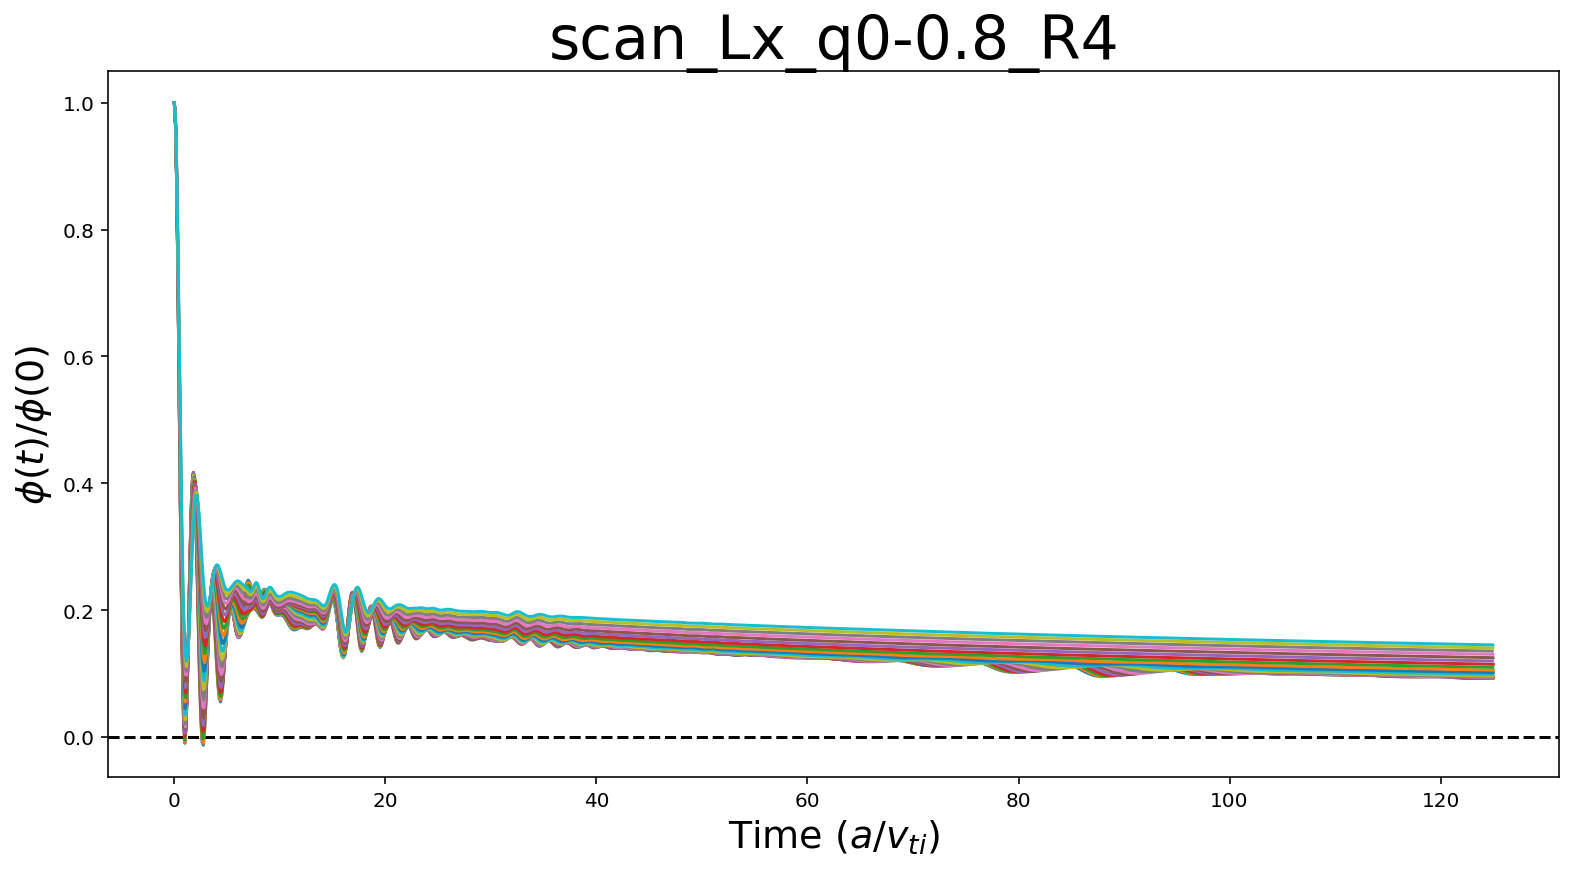

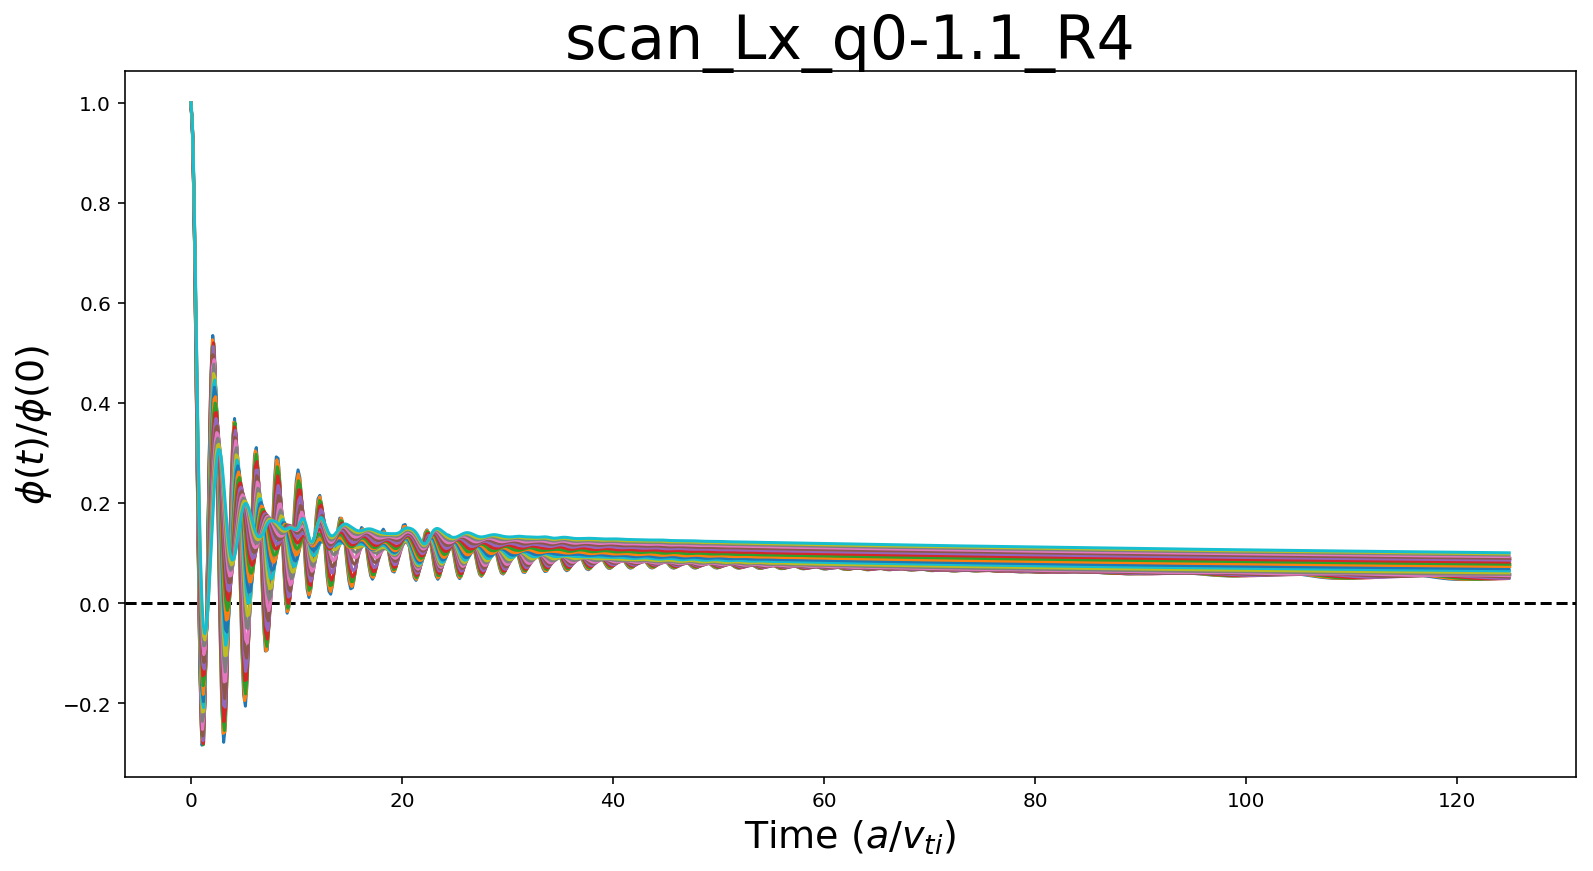

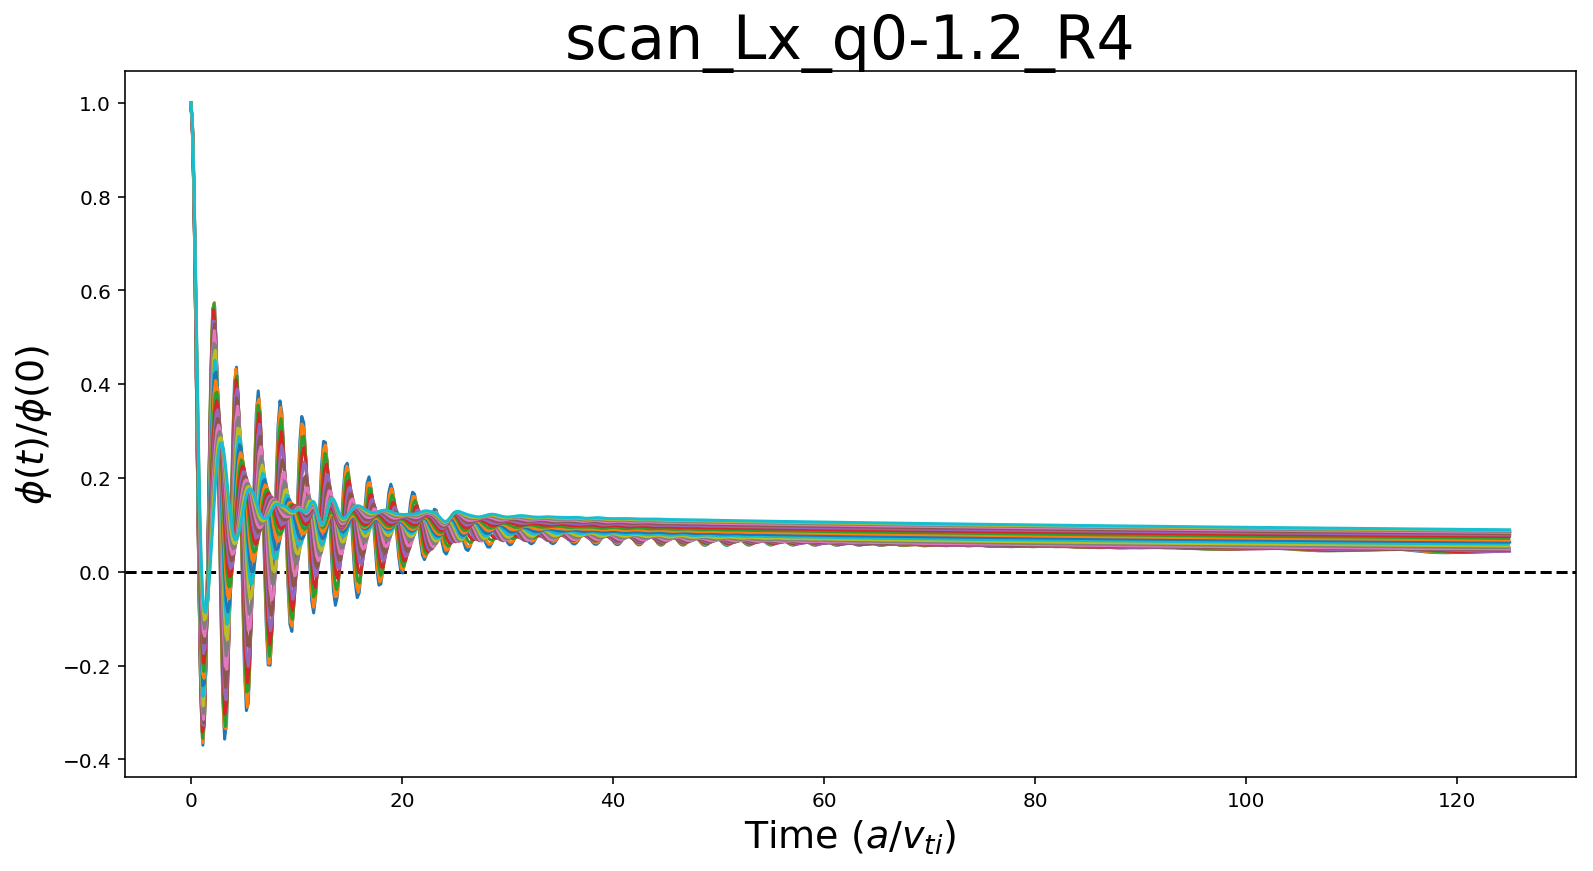

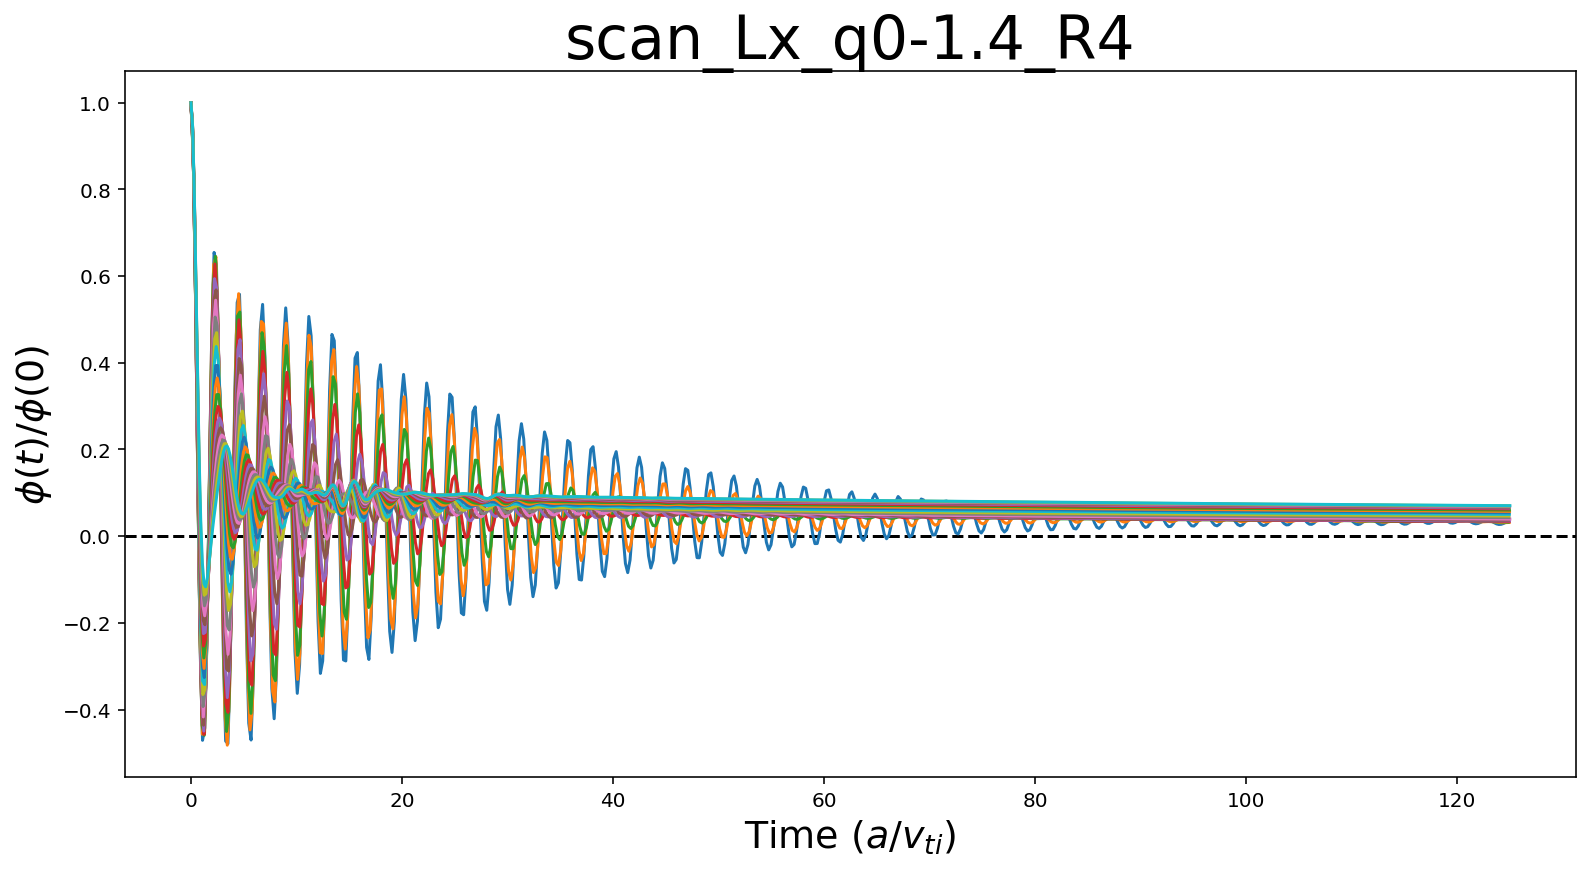

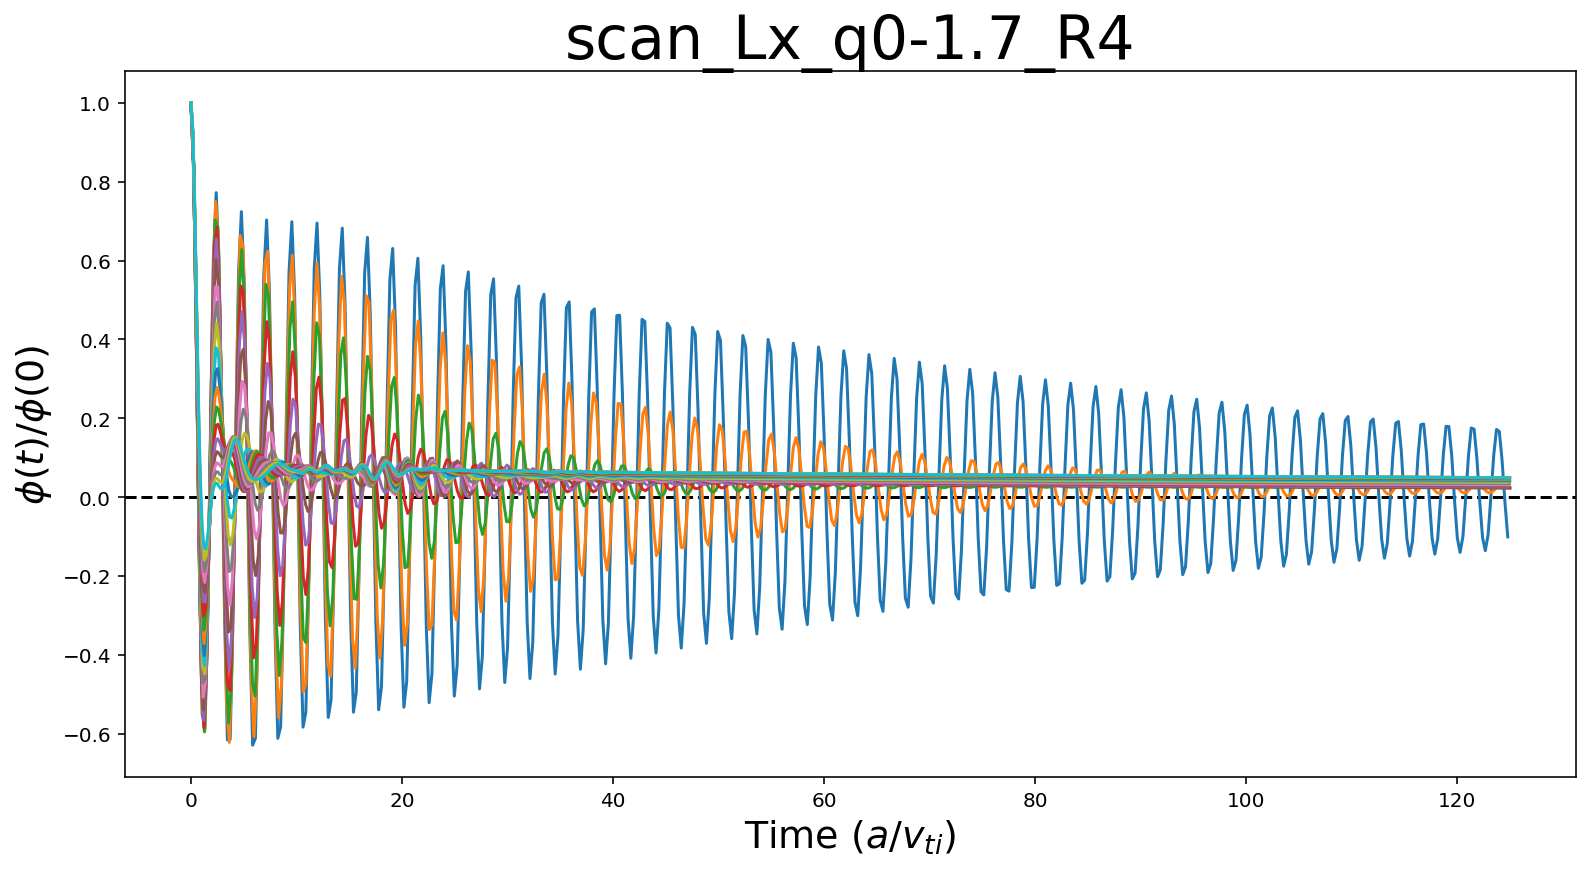

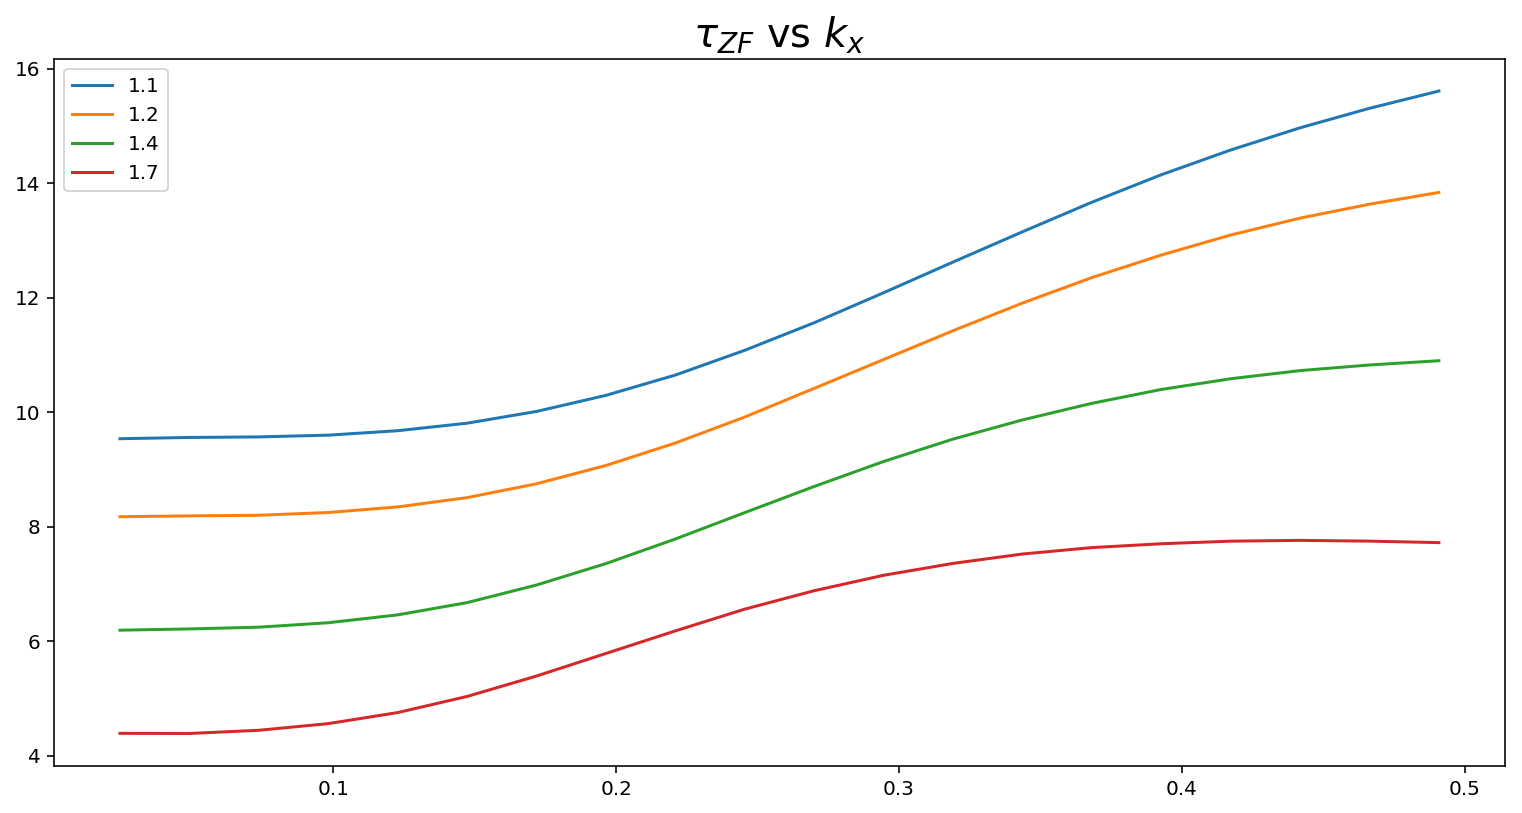

In [33]:
minlim=0
maxlim=20
kx, integ_1, decay, gam, resid, E, t, label = get_zf('scan_Lx_q0-0.8_R4', minlim, maxlim, plot=True, k=None, Lx=256, nkx0=128)
kx, integ_2, decay, gam, resid, E, t, label = get_zf('scan_Lx_q0-1.1_R4', minlim, maxlim, plot=True, k=None, Lx=256, nkx0=128)
kx, integ_3, decay, gam, resid, E, t, label = get_zf('scan_Lx_q0-1.2_R4', minlim, maxlim, plot=True, k=None, Lx=256, nkx0=128)
kx, integ_4, decay, gam, resid, E, t, label = get_zf('scan_Lx_q0-1.4_R4', minlim, maxlim, plot=True, k=None, Lx=256, nkx0=128)
kx, integ_5, decay, gam, resid, E, t, label = get_zf('scan_Lx_q0-1.7_R4', minlim, maxlim, plot=True, k=None, Lx=256, nkx0=128)

plt.figure(figsize=(13, 6.5))
plt.title("$\\tau_{ZF}$ vs $k_{x}$", fontsize=20)
Lxmax = 256
kx_minimum = 2*np.pi/Lxmax
nkx0 = 128
a = np.linspace((kx_minimum), (kx_minimum)*((nkx0//2)-1), (nkx0//2)-1)
#plt.plot(a[minlim:maxlim], integ_1, label='0.8')
plt.plot(a[minlim:maxlim], integ_2, label='1.1')
plt.plot(a[minlim:maxlim], integ_3, label='1.2')
plt.plot(a[minlim:maxlim], integ_4, label='1.4')
plt.plot(a[minlim:maxlim], integ_5, label='1.7')
plt.legend()

plt.show()

Weird! It is:  83.333
Weird! It is:  62.5


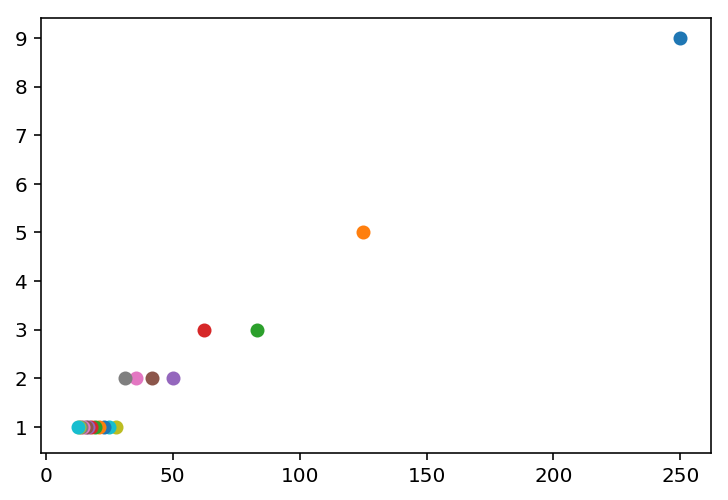

Weird! It is:  0.22089323345553236
Weird! It is:  0.24543692606170261
Weird! It is:  0.2699806186678729
Weird! It is:  0.2945243112740431
Weird! It is:  0.3190680038802134
Weird! It is:  0.3436116964863837
Weird! It is:  0.36815538909255396
Weird! It is:  0.39269908169872414
Weird! It is:  0.4172427743048944
Weird! It is:  0.4417864669110647
Weird! It is:  0.466330159517235
Weird! It is:  0.4908738521234053


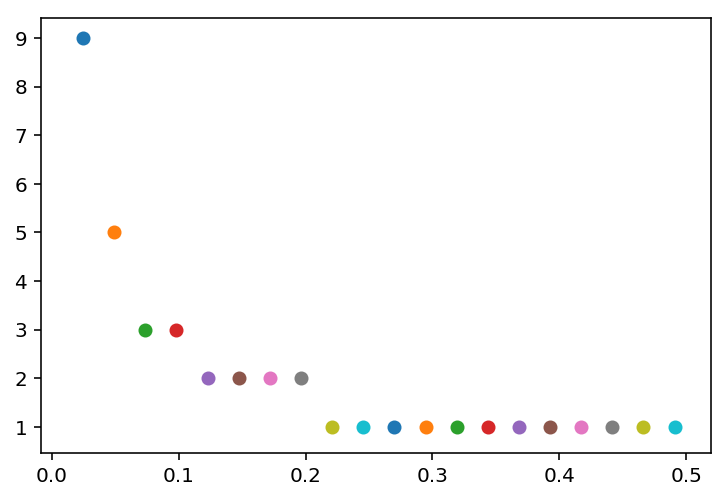

In [71]:
def nexc(Lx, shat=0.78):
    if x[-1] <= 1:
        print('input is kx')
        nexc= np.ceil(0.9*(2*np.pi/x)*(shat)*0.05)
    elif x[-1] >=1:
        print('input is Lx')
        nexc= np.ceil(0.9*Lx*(shat)*0.05)
    return nexc
def nexc_single(x, shat=0.78):
    if x <= 1:
        #print('input is kx')
        nexc= np.ceil(0.9*(2*np.pi/x)*(shat)*0.05)
    elif x >= 1:
        # print('input is Lx')
        nexc= np.ceil(0.9*x*(shat)*0.05)
    return nexc

Lx_test = np.array([250.000, 125.000, 83.333, 62.500, 50.000, 
                     41.667, 35.714, 31.250, 27.778, 25.000, 
                     22.727, 20.833, 19.231, 17.857, 16.667, 
                     15.625, 14.706, 13.889, 13.158, 12.500])
kx_test = a[minlim:maxlim]
#Lx_test = np.linspace(145, 288, 1000)

plt.figure()
for n in range(len(Lx_test)):
    m = n  #len(Lx_test)-1-n
    plt.scatter(Lx_test[m], nexc_single(Lx_test[m]))
    if nexc_single(Lx_test[m]) == 3:
        print('Weird! It is: ', Lx_test[m])
plt.show()

plt.figure()
for n in range(len(kx_test)):
    m = n  #len(Lx_test)-1-n
    plt.scatter(kx_test[m], nexc_single(kx_test[m]))
    if nexc_single(kx_test[m]) == 1:
        print('Weird! It is: ', kx_test[m])
plt.show()


In [ ]:
minlim=0
maxlim=10
kx, integ, decay, gam, resid, E, t, label = get_zf('scan_R_lq', minlim, maxlim, plot=True, k=None, Lx=100, nkx0=2, dR=True)
kx, integ1, decay1, gam1, resid1, E, t, label = get_zf('scan_R_hq', minlim, maxlim, plot=True, k=None, Lx=100, nkx0=2, dR=True)
kx, integ2, decay2, gam2, resid2, E, t, label = get_zf('scan_R_uhq', minlim, maxlim, plot=True, k=None, Lx=100, nkx0=2, dR=False)

intefield = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.figure(figsize=(13, 6.5))
plt.title("$\gamma_{G}$ vs R", fontsize=20)
plt.plot(intefield[minlim:maxlim], decay, label='LQ')
plt.plot(intefield[minlim:maxlim], decay1, label='q0: 1.4')
plt.plot(intefield[minlim:maxlim], decay2, label='q0: 1.2')
plt.legend()
plt.show()

plt.figure(figsize=(13, 6.5))
plt.title("Residual contribution to $\\tau_{ZF}$ vs R", fontsize=20)
plt.plot(intefield[minlim:maxlim], resid, label='LQ')
plt.plot(intefield[minlim:maxlim], resid1, label='q0: 1.4')
plt.plot(intefield[minlim:maxlim], resid2, label='q0: 1.2')
plt.legend()
plt.show()

plt.figure(figsize=(13, 6.5))
plt.title("GAM contribution to $\\tau_{ZF}$ vs R", fontsize=20)
plt.plot(intefield[minlim:maxlim], gam, label='LQ')
plt.plot(intefield[minlim:maxlim], gam1, label='q0: 1.4')
plt.plot(intefield[minlim:maxlim], gam2, label='q0: 1.2')
plt.legend()
plt.show()

plt.figure(figsize=(13, 6.5))
plt.title("$\\tau_{ZF}$ vs R", fontsize=20)
plt.plot(intefield[minlim:maxlim], integ, label='LQ')
plt.plot(intefield[minlim:maxlim], integ1, label='q0: 1.4')
plt.plot(intefield[minlim:maxlim], integ2, label='q0: 1.2')
plt.legend()
plt.show()

## Checking if the integration of Nunami's GAM response is accurate (@ kx=0.25)

In [ ]:
troubleshooter(E3, t3, label5)

In [ ]:
#ρ_eff=√ψ_N
x = np.linspace(0, 1, 100)
y = np.sqrt(x)
plt.figure()
plt.plot(x, y)
plt.xlabel('$\Psi_{N}$', fontsize=14)
plt.ylabel('$\\rho_{eff}$', fontsize=14)
plt.show()

In [ ]:
mxtime = 25
kx1, integR1, decayR1, gamR1,residR1, E1, t1, label1 = get_zf('rho_0.46', minlim=1, maxlim=2,
                                                              plot=True, k=None, Lx=25.1327412287,
                                                              nkx0=1, dR=True, R=3.6731507, mxtime=mxtime)
sa_E = E1
sa_t = t1
%store sa_E
%store sa_t

kx2, integR2, decayR2, gamR2, residR2, E2, t2, label2 = get_zf('rho_0.57', minlim=1, maxlim=2,
                                                               plot=True, k=None, Lx=25.1327412287,
                                                               nkx0=1, dR=True, R=3.6731507, mxtime=mxtime)
kx3, integR3, decayR3, gamR3, residR3, E3, t3, label3 = get_zf('rho_0.65', minlim=1, maxlim=2,
                                                               plot=True, k=None, Lx=25.1327412287,
                                                               nkx0=1, dR=True, R=3.6731507, mxtime=mxtime)
kx4, integR4, decayR4, gamR4, residR4, E4, t4, label4 = get_zf('rho_0.72', minlim=1, maxlim=2,
                                                               plot=True, k=None, Lx=25.1327412287,
                                                               nkx0=1, dR=True, R=3.6731507, mxtime=mxtime)
kx5, integR5, decayR5, gamR5, residR5, E5, t5, label5 = get_zf('rho_0.83', minlim=1, maxlim=2,
                                                               plot=True, k=None, Lx=25.1327412287,
                                                               nkx0=1, dR=True, R=3.6731507, mxtime=mxtime)
plt.figure(figsize=(13, 6.5))
plt.title("$\\tau_{ZF}$ vs integration range", fontsize=20)
for n in range(len(E1)):
    intefield = np.trapz(E1[:n], t1[:n])
    plt.scatter(t1[n], intefield)
for n in range(len(E2)):
    intefield = np.trapz(E2[:n], t2[:n])
    plt.scatter(t2[n], intefield)
for n in range(len(E3)):
    intefield = np.trapz(E3[:n], t3[:n])
    plt.scatter(t3[n], intefield)
for n in range(len(E4)):
    intefield = np.trapz(E4[:n], t4[:n])
    plt.scatter(t4[n], intefield)
for n in range(len(E5)):
    intefield = np.trapz(E5[:n], t5[:n])
    plt.scatter(t5[n], intefield)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.show()
print(integR1, integR2, integR3, integR4, integR5)